# The impact of participation in a sale flyer campaign on stores revenue

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import itertools
import statsmodels.api as sm

from causalinference import CausalModel
from joblib import Parallel, delayed
from matplotlib import gridspec
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import kstest, skew, kurtosis, chi2_contingency, mannwhitneyu
from scipy.stats.contingency import crosstab

In [2]:
sns.set_style("whitegrid")
pd.options.display.float_format = '{:.3f}'.format
%precision 5

'%.5f'

# 1. Exploratory data analysis

In [3]:
data_raw = pd.read_csv("data/data.csv", sep=";", decimal=",")
data_raw.columns = [
    'name', 'vivodeship', 'revenue22', 'receipts22', 'floor_surface',
    'campaign_months', 'revenue21', 'receipts21', 'online_views',
    'no_printed', 'age', 'campaign'
]
data_raw = data_raw[[
    'revenue22', 'receipts22', 'revenue21', 'receipts21', 
    'vivodeship',  'floor_surface', 'age',
    'online_views', 'no_printed',
    'campaign_months',   'campaign'
]]
data_raw.head()

,revenue22,receipts22,revenue21,receipts21,vivodeship,floor_surface,age,online_views,no_printed,campaign_months,campaign
0,10454691,142116,9368169.360,143776,dolnośląskie,1300,4,13872,48000,10,1
1,9177000,139577,8707300.000,135905,małopolskie,1000,3,3994,40000,4,0
2,1704681,26371,1862117.500,22898,warmińsko-mazurskie,450,3,0,0,0,0
3,3972726,57908,5415980.000,73552,lubuskie,900,4,3848,42000,7,0
4,6081370,88310,6115349.510,96585,zachodniopomorskie,1800,2,1573,0,4,0


In [4]:
data_raw.shape

(336, 11)

3 new variables were created:
- "Basket" equal to the ratio of revenues for 2022 by the number of receipts for 2022
-  Revenue per square meter in 2021 equal to the ratio of revenue in 2021 by the store area
-  Revenue per square meter in 2022 equal to the ratio of revenue in 2022 by the store area

In [5]:
data_raw["basket"] = data_raw["revenue22"] / data_raw["receipts22"]
data_raw["revenue_m2_21"] = data_raw["revenue21"] / data_raw["floor_surface"]
data_raw["revenue_m2_22"] = data_raw["revenue22"] / data_raw["floor_surface"]

### 1.1. Receipts analysis

The number of receipts is analyzed in order to exclude wholesale and retail outlets from the set. For this purpose, shops that did not report the number of receipts were removed from the population. Then, all shops that are marked as outliers and extremes in the boxplot of receipts were removed.

The revenue in 2022 is higher than in 2021, but this does not translate into the number of receipts. This is probably due to the inflation.

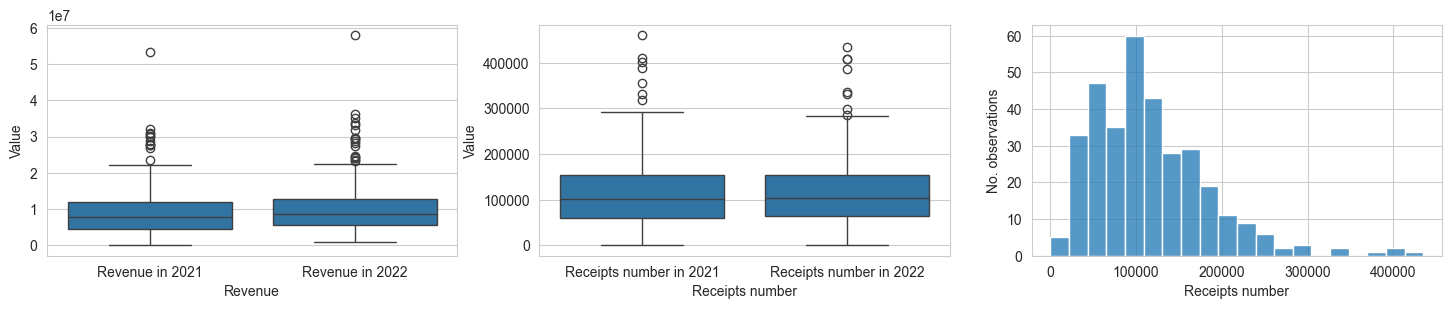

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3))

data_tmp = pd.melt(data_raw[["revenue21", "revenue22"]])
data_tmp["variable"] = data_tmp["variable"].map({'revenue21': 'Revenue in 2021', 'revenue22': 'Revenue in 2022'})
sns.boxplot(x="variable", y="value", data=data_tmp, ax=axs[0])

data_tmp = pd.melt(data_raw[["receipts21", "receipts22"]])
data_tmp["variable"] = data_tmp["variable"].map({'receipts21': 'Receipts number in 2021', 'receipts22': 'Receipts number in 2022'})
sns.boxplot(x="variable", y="value", data=data_tmp, ax=axs[1])

sns.histplot(data=data_raw, x="receipts22", ax=axs[2], bins=20)
axs[2].set(ylabel="No. observations", xlabel="Receipts number")

axs[0].set(xlabel="Revenue", ylabel="Value")
axs[1].set(ylabel="Value", xlabel="Receipts number")
plt.show()

The number of shop branches without receipts in 2022 is 10. They also include branches that did not issue receipts in 2021.

In [7]:
print(f"Number of shops not reporting receipts in 2021: {data_raw.query('receipts21==0').shape[0]}")
print(f"Number of shops not reporting receipts in 2022: {data_raw.query('receipts22==0').shape[0]}")
print(f"Number of shops not reporting receipts in 2021 iand 2022: {data_raw.query('receipts21==0 and receipts22==0').shape[0]}")

Number of shops not reporting receipts in 2021: 10
Number of shops not reporting receipts in 2022: 3
Number of shops not reporting receipts in 2021 iand 2022: 3


In [8]:
# delete shops without receipts
data_raw = data_raw.query("receipts21!=0 and receipts22!=0")
data_raw.shape

(326, 14)

### 1.1. Average basket

Calculation of the average amount on the receipt - basket in 2022

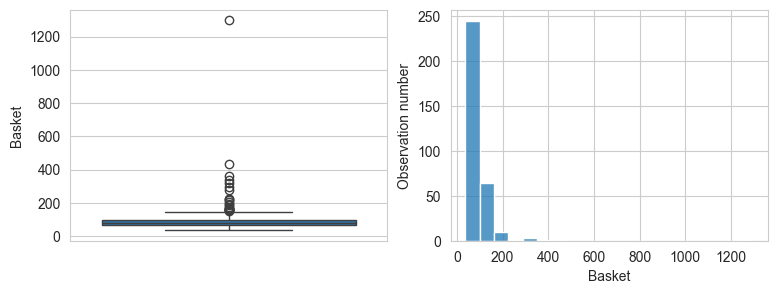

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
sns.boxplot(data=data_raw, y="basket", ax=axs[0])
sns.histplot(data=data_raw, x="basket", ax=axs[1], bins=20)
axs[0].set(ylabel="Basket")
axs[1].set(ylabel="Observation number", xlabel="Basket")
plt.show()

In the next step, stores whose average basket value was significantly different from the remaining values ​​in the population were removed.

In [10]:
q1, q3 = np.quantile(data_raw["basket"], [.2, .7])
outlier_bottom_thr = q1 - 1.5 * (q3 - q1)
outlier_top_thr = q3 + 1.5 * (q3 - q1)
print(f"Lower threshold: {round(outlier_bottom_thr, 3)} PLN")
print(f"Upper thershold: {round(outlier_top_thr, 3)} PLN")

Lower threshold: 21.482 PLN
Upper thershold: 131.547 PLN


In [11]:
data_raw["basket"].sort_values().head(10)

135   35.532
52    36.514
330   37.741
250   37.786
188   38.111
265   40.189
126   41.105
234   43.292
36    43.331
199   46.302
Name: basket, dtype: float64

In [12]:
data_raw["basket"].sort_values().tail(10)

88     218.740
157    222.191
295    222.816
27     277.774
22     295.312
134    318.223
197    338.440
230    362.237
154    435.495
114   1298.687
Name: basket, dtype: float64

In [13]:
# outliers removal
data_raw = data_raw.query("basket > 35 and basket < 145")
data_raw.shape

(304, 14)

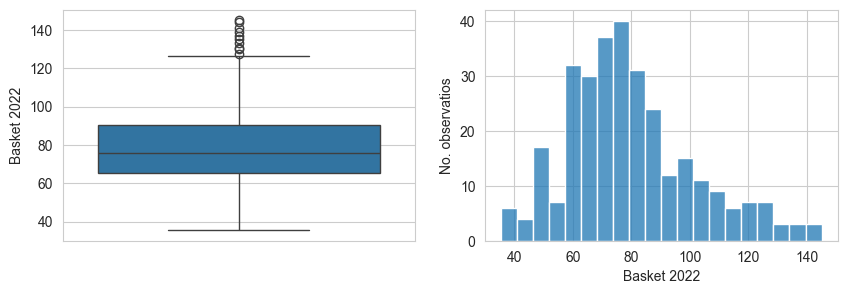

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(data=data_raw, y="basket", ax=axs[0])
sns.histplot(data=data_raw, x="basket", ax=axs[1], bins=20)
axs[0].set(ylabel="Basket 2022")
axs[1].set(ylabel="No. observatios", xlabel="Basket 2022")
plt.show()

In [15]:
data_raw[[
    'revenue22', 'revenue21', 'revenue_m2_21', 'revenue_m2_22',
    'floor_surface', 'age', 
    'online_views', 'no_printed', 'campaign_months', 'campaign', 'basket',
]].describe().T[['mean', 'std', 'min', '50%', 'max']]

,mean,std,min,50%,max
revenue22,9849437.553,6793438.572,904563.000,8292024.000,57966634.000
revenue21,8852075.344,6352581.695,502492.010,7574613.215,53299587.480
revenue_m2_21,6252.821,3233.437,261.657,5701.949,23512.396
revenue_m2_22,6904.791,3222.162,1186.415,6256.569,24752.813
floor_surface,1512.586,897.352,180.000,1350.000,5000.000
age,7.243,4.196,1.000,7.000,19.000
online_views,5824.201,6131.705,0.000,4757.000,41385.000
no_printed,32992.602,64604.497,0.000,10000.000,500000.000
campaign_months,5.882,4.201,0.000,8.000,10.000
campaign,0.533,0.500,0.000,1.000,1.000


### 1.3. Participation in a sale flyer campaign

In [16]:
test_prcnt = data_raw.query("campaign==1").shape[0] / data_raw.shape[0]
control_prcnt = data_raw.query("campaign==0").shape[0] / data_raw.shape[0]
print(f"Fraction of shops participating in a sale flyer campaign: {round(test_prcnt*100, 3)} ({data_raw.query('campaign==1').shape[0]})")
print(f"Fraction of shops not participating in a sale flyer campaign: {round(control_prcnt*100, 3)} ({data_raw.query('campaign==0').shape[0]})")

Fraction of shops participating in a sale flyer campaign: 53.289 (162)
Fraction of shops not participating in a sale flyer campaign: 46.711 (142)


#### 1.3.1. Sale flyer campaign - ordered variable

In [17]:
np.quantile(data_raw['campaign_months'], q=[0.33, 0.66])

array([2.99, 9.  ])

In [18]:
# 3 levels
data_raw.loc[data_raw['campaign_months'] < 3, "campaign_3"] = 0
data_raw.loc[data_raw['campaign_months'].between(3, 9), "campaign_3"] = 1
data_raw.loc[data_raw['campaign_months'] == 10, "campaign_3"] = 2
data_raw = data_raw.astype({'campaign_3': 'int'})

In [19]:
pd.concat([data_raw['campaign_3'].value_counts(), (data_raw['campaign_3'].value_counts() / data_raw.shape[0] * 100).round(3).astype(str) + "%"], axis=1).sort_index()

,count,count
campaign_3,,
0,100,32.895%
1,110,36.184%
2,94,30.921%


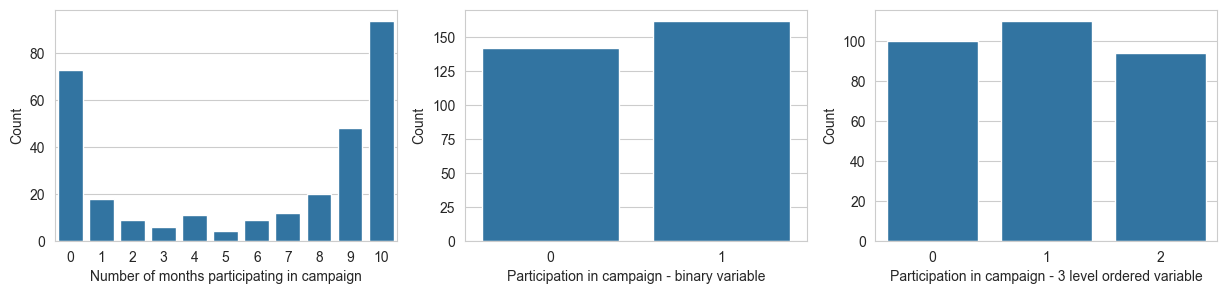

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
ax1 = sns.countplot(x ='campaign_months', data=data_raw, ax=axs[0])
ax1.set(ylabel="Count", xlabel="Number of months participating in campaign")
ax2 = sns.countplot(x ='campaign', data=data_raw, ax=axs[1])
ax2.set(ylabel="Count", xlabel="Participation in campaign - binary variable")
ax3 = sns.countplot(x ='campaign_3', data=data_raw, ax=axs[2])
ax3.set(ylabel="Count", xlabel="Participation in campaign - 3 level ordered variable")
plt.show()

### 1.4. Revenue per squared meter

In [21]:
data_raw[["revenue_m2_21", "revenue_m2_22"]].describe().T

,count,mean,std,min,25%,50%,75%,max
revenue_m2_21,304.000,6252.821,3233.437,261.657,4265.477,5701.949,7481.034,23512.396
revenue_m2_22,304.000,6904.791,3222.162,1186.415,5036.999,6256.569,8196.663,24752.813


In [22]:
data_raw[["revenue_m2_22", "campaign"]].groupby("campaign").describe()

revenue_m2_22                                                        \
                 count     mean      std      min      25%      50%      75%   
campaign                                                                       
0              142.000 6745.631 3656.737 1186.415 4284.820 6138.265 8151.096   
1              162.000 7044.301 2790.491 2679.701 5332.602 6472.403 8172.680   

                    
               max  
campaign            
0        21006.693  
1        24752.813

In [23]:
data_raw[["revenue_m2_22", "campaign_3"]].groupby("campaign_3").describe()

revenue_m2_22                                               \
                   count     mean      std      min      25%      50%   
campaign_3                                                              
0                100.000 6589.081 3831.167 1186.415 3869.353 5883.061   
1                110.000 6900.716 2853.693 2175.598 5007.398 6341.017   
2                 94.000 7245.420 2903.863 3124.217 5533.513 6626.454   

                               
                75%       max  
campaign_3                     
0          7975.672 21006.693  
1          7890.901 16600.369  
2          8312.606 24752.813

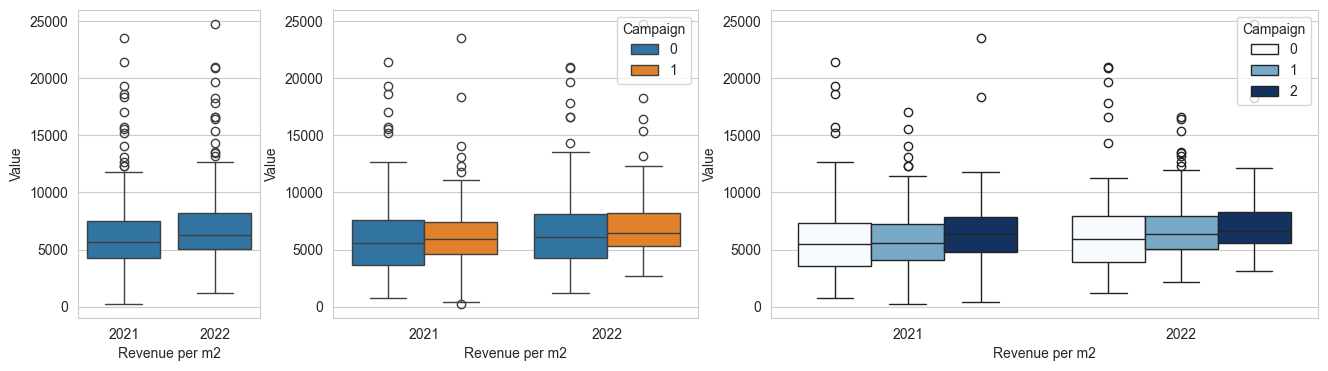

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 2, 3]})

data_raw_tmp = pd.melt(data_raw[["revenue_m2_21", "revenue_m2_22", "campaign", "campaign_3"]], id_vars=["campaign", "campaign_3"])
data_raw_tmp["variable"] = data_raw_tmp["variable"].map({'revenue_m2_22': '2022', 'revenue_m2_21': '2021'})
ax1 = sns.boxplot(x="variable", y="value", data=data_raw_tmp, ax=axs[0])
ax1.set(xlabel="Revenue per m2", ylabel="Value")

ax2 = sns.boxplot(x="variable", y="value", hue="campaign", data=data_raw_tmp, ax=axs[1])
ax2.set(xlabel="Revenue per m2", ylabel="Value")
ax2.legend(loc='upper right', title="Campaign")

ax3 = sns.boxplot(x="variable", y="value", hue="campaign_3", data=data_raw_tmp, ax=axs[2], palette="Blues")
ax3.set(xlabel="Revenue per m2", ylabel="Value")
ax3.legend(loc='upper right', title="Campaign")

plt.show()

In [25]:
mu,sigma = 0.07, 0.89
kstest(np.random.normal(data_raw["revenue_m2_22"].mean(), data_raw["revenue_m2_22"].std(), 10000), data_raw["revenue_m2_22"])

KstestResult(statistic=0.12118947368421053, pvalue=0.0003105445077993853, statistic_location=7492.575, statistic_sign=-1)

In [26]:
data_raw[["revenue_m2_22", "campaign"]].groupby("campaign").agg(["mean", "count", "std"])

revenue_m2_22               
                  mean count      std
campaign                             
0             6745.631   142 3656.737
1             7044.301   162 2790.491

In [27]:
t, c = data_raw[data_raw["campaign"] == 1]["revenue_m2_22"], data_raw[data_raw["campaign"] == 0]["revenue_m2_22"]
U1, p = mannwhitneyu(t, c, method="exact", alternative="greater")
U1, p

(12858.00000, 0.03813)

In [28]:
skew(data_raw["revenue_m2_22"]), skew(data_raw["revenue_m2_21"])
kurtosis(data_raw["revenue_m2_22"]), kurtosis(data_raw["revenue_m2_21"])

(6.04473, 5.61226)

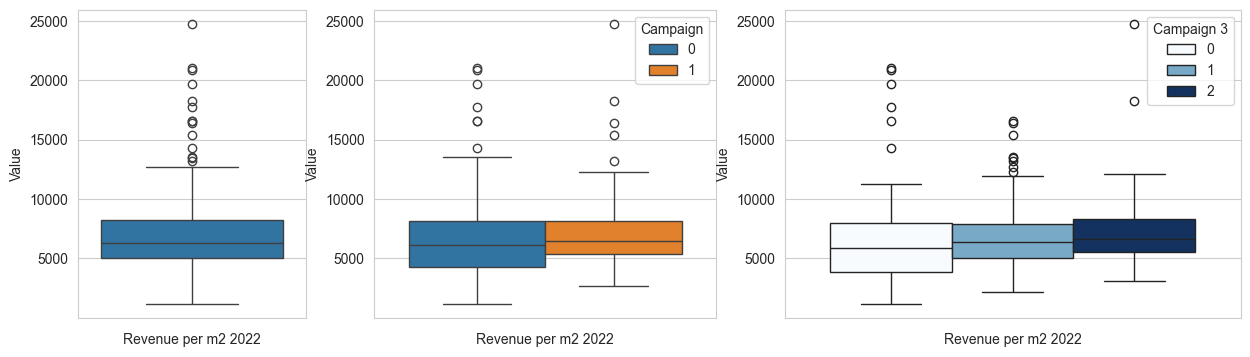

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={'width_ratios': [1, 1.5, 2]})

ax1 = sns.boxplot(y="revenue_m2_22", data=data_raw, ax=axs[0])
ax1.set(xlabel="Revenue per m2 2022", ylabel="Value")

ax2 = sns.boxplot(y="revenue_m2_22", hue="campaign", data=data_raw, ax=axs[1])
ax2.set(xlabel="Revenue per m2 2022", ylabel="Value")
ax2.legend(loc='upper right', title="Campaign")

ax3 = sns.boxplot(y="revenue_m2_22", hue="campaign_3", data=data_raw, ax=axs[2], palette="Blues")
ax3.set(xlabel="Revenue per m2 2022", ylabel="Value")
ax3.legend(loc='upper right', title="Campaign 3")

plt.show()

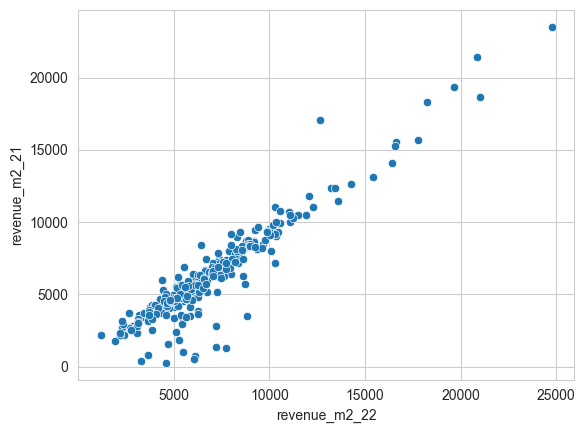

In [30]:
sns.scatterplot(x=data_raw["revenue_m2_22"], y=data_raw["revenue_m2_21"])
plt.show()

### 1.5. Regional analysis

Because the stores are located in smaller towns, the differences occur at the district level, not the voivodeship level. Therefore, voivodeships will be excluded from further analysis because they do not provide additional information on revenues.

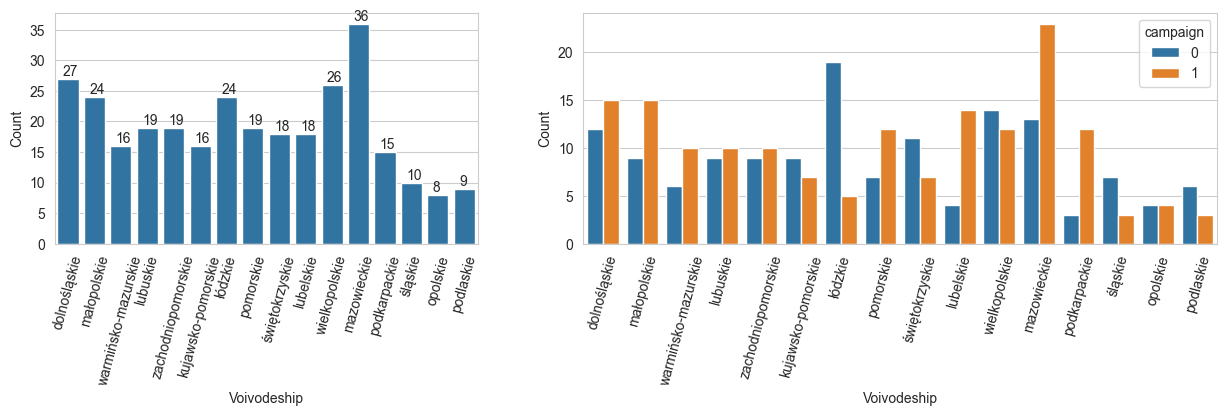

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3), gridspec_kw={'width_ratios': [2, 3]})
ax1 = sns.countplot(x ='vivodeship', data=data_raw, ax=axs[0])
axs[0].tick_params(axis='x', rotation=75)
for p in ax1.patches:
    ax1.annotate(int(p.get_height()), (p.get_x() + p.get_width()/4, p.get_height() + .5))
ax2 = sns.countplot(x ='vivodeship', data=data_raw, hue="campaign", ax=axs[1])
axs[1].tick_params(axis='x', rotation=75)
ax1.set(ylabel="Count", xlabel="Voivodeship")
ax2.set(ylabel="Count", xlabel="Voivodeship")
plt.show()

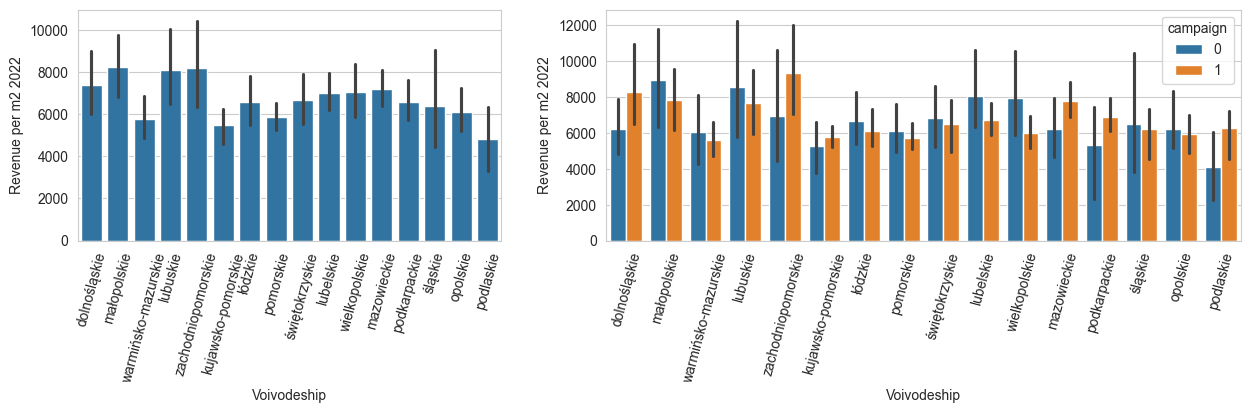

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3), gridspec_kw={'width_ratios': [2, 3]})
ax1 = sns.barplot(data=data_raw, x="vivodeship", y="revenue_m2_22", ax=axs[0])
axs[0].tick_params(axis='x', rotation=75)
ax2 = sns.barplot(data=data_raw, x="vivodeship", y="revenue_m2_22", hue="campaign", ax=axs[1])
axs[1].tick_params(axis='x', rotation=75)
ax1.set(xlabel="Voivodeship", ylabel="Revenue per m2 2022")
ax2.set(xlabel="Voivodeship", ylabel="Revenue per m2 2022")
plt.show()

In [33]:
data_raw["vivodeship"].value_counts()

vivodeship
mazowieckie            36
dolnośląskie           27
wielkopolskie          26
małopolskie            24
łódzkie                24
lubuskie               19
zachodniopomorskie     19
pomorskie              19
świętokrzyskie         18
lubelskie              18
warmińsko-mazurskie    16
kujawsko-pomorskie     16
podkarpackie           15
śląskie                10
podlaskie               9
opolskie                8
Name: count, dtype: int64

### 1.6. Shop surface analysis

In [34]:
data_raw[["floor_surface"]].describe().T

,count,mean,std,min,25%,50%,75%,max
floor_surface,304.000,1512.586,897.352,180.000,890.000,1350.000,1900.000,5000.000


In [35]:
data_raw[["floor_surface", "campaign"]].groupby("campaign").describe()

floor_surface                                                      \
                 count     mean     std     min      25%      50%      75%   
campaign                                                                     
0              142.000 1212.430 817.282 180.000  600.000 1000.000 1600.000   
1              162.000 1775.685 883.949 300.000 1192.500 1600.000 2147.500   

                   
              max  
campaign           
0        4100.000  
1        5000.000

In [36]:
data_raw[["floor_surface", "campaign_3"]].groupby("campaign_3").describe()

floor_surface                                                      \
                   count     mean     std     min      25%      50%      75%   
campaign_3                                                                     
0                100.000 1041.650 695.744 180.000  507.500  790.000 1400.000   
1                110.000 1695.409 945.916 360.000 1000.000 1400.000 2200.000   
2                 94.000 1799.638 835.614 300.000 1257.500 1675.000 2000.000   

                     
                max  
campaign_3           
0          3500.000  
1          5000.000  
2          5000.000

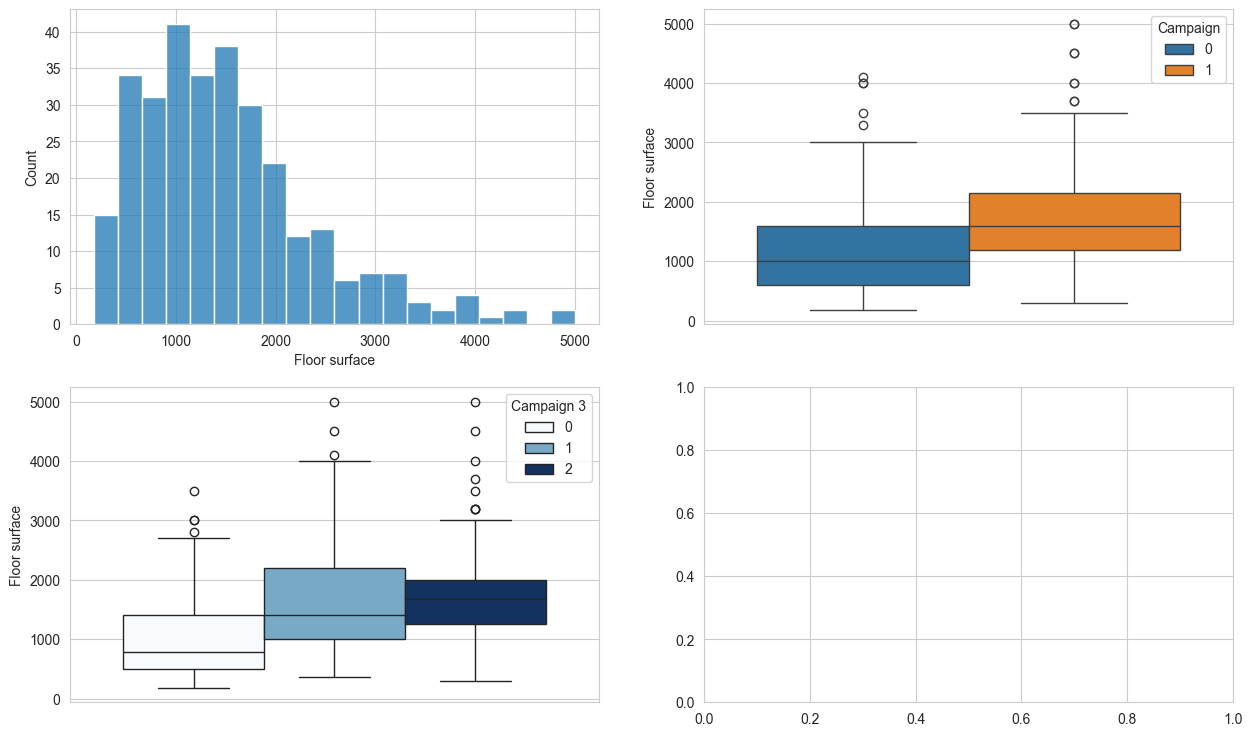

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))
sns.histplot(data=data_raw, x="floor_surface", ax=axs[0, 0], bins=20)
axs[0, 0].set(ylabel="Count", xlabel="Floor surface")
sns.boxplot(data=data_raw, y="floor_surface", hue="campaign", ax=axs[0, 1])
axs[0, 1].set(ylabel="Floor surface")
axs[0, 1].legend(loc='upper right', title="Campaign")
sns.boxplot(data=data_raw, y="floor_surface", hue="campaign_3", ax=axs[1, 0], palette="Blues")
axs[1, 0].set(ylabel="Floor surface")
axs[1, 0].legend(loc='upper right', title="Campaign 3")
plt.show()

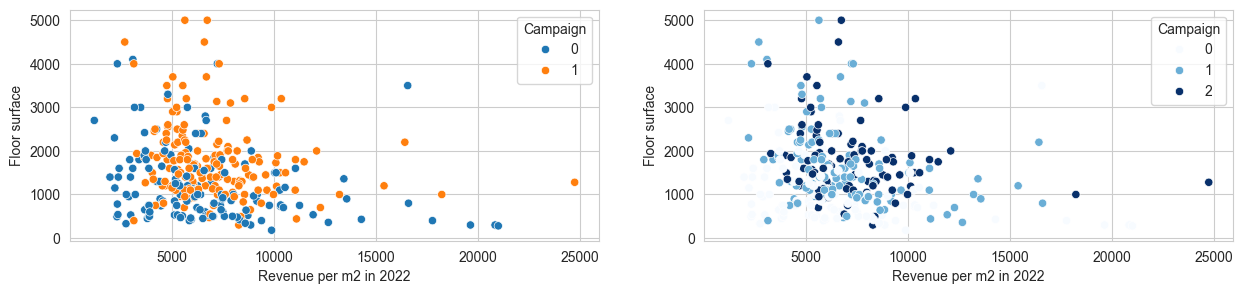

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
ax1 = sns.scatterplot(data=data_raw, x="revenue_m2_22", y="floor_surface", hue="campaign", ax=axs[0])
ax1.set(xlabel="Revenue per m2 in 2022", ylabel="Floor surface")
axs[0].legend(loc='upper right', title="Campaign")
ax2 = sns.scatterplot(data=data_raw, x="revenue_m2_22", y="floor_surface", hue="campaign_3", ax=axs[1], palette="Blues")
ax2.set(xlabel="Revenue per m2 in 2022", ylabel="Floor surface")
axs[1].legend(loc='upper right', title="Campaign")
plt.show()

In [39]:
data_raw[["revenue_m2_22", "floor_surface"]].corr("spearman")

,revenue_m2_22,floor_surface
revenue_m2_22,1.000,-0.210
floor_surface,-0.210,1.000


#### 1.6.1. Floor surface categorisation

In [40]:
np.quantile(data_raw["floor_surface"], q=[0.25, 0.5, 0.75])

array([ 890., 1350., 1900.])

In [41]:
data_raw.loc[data_raw["floor_surface"] < 890, "floor_surface_rang"] = 0
data_raw.loc[data_raw["floor_surface"].between(890, 1350), "floor_surface_rang"] = 1
data_raw.loc[data_raw["floor_surface"].between(1350, 1900), "floor_surface_rang"] = 2
data_raw.loc[data_raw["floor_surface"] > 1900, "floor_surface_rang"] = 3

In [42]:
data_raw[["revenue_m2_22", "floor_surface_rang"]].corr("spearman")

,revenue_m2_22,floor_surface_rang
revenue_m2_22,1.000,-0.186
floor_surface_rang,-0.186,1.000


In [43]:
data_raw["floor_surface_rang"] = data_raw["floor_surface_rang"].map({0: "S", 1: "M", 2: "L", 3: "XL"})

#### 1.6.2. The influence of floor area on participation in the sale flyer campaign - the case of an ordered variable

In [44]:
freq_table = crosstab(data_raw["campaign_3"], data_raw["floor_surface_rang"])
pd.DataFrame(
    freq_table.count,
    index = freq_table.elements[0],
    columns = freq_table.elements[1],
).loc[:,["S", "M", "L", "XL"]]

,S,M,L,XL
0,54,18,16,12
1,15,33,31,31
2,7,23,33,31


In [45]:
res = chi2_contingency(freq_table.count)
res

Chi2ContingencyResult(statistic=70.76053698572848, pvalue=2.854791799214478e-13, dof=6, expected_freq=array([[26.31579, 24.34211, 25.     , 24.34211],
       [28.94737, 26.77632, 27.5    , 26.77632],
       [24.73684, 22.88158, 23.5    , 22.88158]]))

p-value < 0.05, there are basis to reject H0

#### 1.6.3. The influence of floor area on participation in the sale flyer campaign - the case of an binary variable

In [46]:
freq_table = crosstab(data_raw["campaign"], data_raw["floor_surface_rang"])
pd.DataFrame(
    freq_table.count,
    index = freq_table.elements[0],
    columns = freq_table.elements[1],
).loc[:,["S", "M", "L", "XL"]]

,S,M,L,XL
0,61,32,27,22
1,15,42,53,52


In [47]:
res = chi2_contingency(freq_table.count)
res

Chi2ContingencyResult(statistic=48.70061798888091, pvalue=1.5106379182321342e-10, dof=3, expected_freq=array([[37.36842, 34.56579, 35.5    , 34.56579],
       [42.63158, 39.43421, 40.5    , 39.43421]]))

Since the p-value is less than 0.05, there are basis to reject H0. The results suggest that there is a relationship between store size and sale flyer campaign participation. Larger stores are more willing to participate in the sale flyer campaign.

#### 1.6.4. The impact of a sale flyer campaign on revenues for different store sizes

In [48]:
for size in data_raw["floor_surface_rang"].unique():
    print("Floor area: ", size)
    data_tmp = data_raw[data_raw["floor_surface_rang"] == size]
    x = data_tmp[data_tmp["campaign"] == 0]["revenue_m2_22"]
    y = data_tmp[data_tmp["campaign"] == 1]["revenue_m2_22"]
    res = mannwhitneyu(x, y, alternative="less", method="exact")
    print("Average revenue of shops not participating in sale flyer campaign: ", np.mean(x))
    print("Average revenue of shops not participating in sale flyer campaign: ", np.mean(y))
    print("P-value: ", res.pvalue)
    print()

Floor area:  M
Average revenue of shops not participating in sale flyer campaign:  6349.939512626139
Average revenue of shops not participating in sale flyer campaign:  7952.255415332093
P-value:  0.03370678590303923

Floor area:  S
Average revenue of shops not participating in sale flyer campaign:  7835.111625710019
Average revenue of shops not participating in sale flyer campaign:  7303.324892720869
P-value:  0.4384231868893881

Floor area:  L
Average revenue of shops not participating in sale flyer campaign:  5946.829113315955
Average revenue of shops not participating in sale flyer campaign:  6934.239604040892
P-value:  0.024560941323397027

Floor area:  XL
Average revenue of shops not participating in sale flyer campaign:  5280.698443592231
Average revenue of shops not participating in sale flyer campaign:  6348.412301914499
P-value:  0.010660568535306031



W przypadku sklepów rozmiaru M, L i XL, sklepy biorące udział in akcji gazetkowej rejestrują statystycznie wyższe przychody.

In [49]:
crosstab(data_raw["campaign"], data_raw["floor_surface_rang"]).count

array([[27, 32, 61, 22],
       [53, 42, 15, 52]])

In [50]:
crosstab(data_raw["campaign"], data_raw["floor_surface_rang"]).count.sum(axis=0)

array([80, 74, 76, 74])

In [51]:
data_raw[["campaign", "floor_surface_rang", "revenue_m2_22"]].groupby(["floor_surface_rang", "campaign"]).count().reset_index()

,floor_surface_rang,campaign,revenue_m2_22
0,L,0,27
1,L,1,53
2,M,0,32
3,M,1,42
4,S,0,61
5,S,1,15
6,XL,0,22
7,XL,1,52


In [52]:
pd.pivot_table(data_raw[["campaign", "floor_surface_rang", "revenue_m2_22"]].groupby(["floor_surface_rang", "campaign"]).count().reset_index(), index=["floor_surface_rang", "campaign"], values="revenue_m2_22")

revenue_m2_22
floor_surface_rang campaign               
L                  0                27.000
                   1                53.000
M                  0                32.000
                   1                42.000
S                  0                61.000
                   1                15.000
XL                 0                22.000
                   1                52.000

### 1.7. Shops age analysis

In [53]:
data_raw[["age"]].describe().T

,count,mean,std,min,25%,50%,75%,max
age,304.000,7.243,4.196,1.000,4.000,7.000,10.000,19.000


In [54]:
data_raw[["age", "campaign"]].groupby("campaign").describe()

age                                            
           count  mean   std   min   25%   50%    75%    max
campaign                                                    
0        142.000 6.732 3.971 1.000 4.000 6.000 10.000 19.000
1        162.000 7.691 4.347 1.000 4.000 8.000 11.000 19.000

In [55]:
data_raw[["age", "campaign_3"]].groupby("campaign_3").describe()

age                                            
             count  mean   std   min   25%   50%    75%    max
campaign_3                                                    
0          100.000 7.090 3.856 1.000 4.000 7.000 10.000 19.000
1          110.000 6.591 4.377 1.000 3.000 6.000 10.000 19.000
2           94.000 8.170 4.206 1.000 5.000 9.000 11.000 19.000

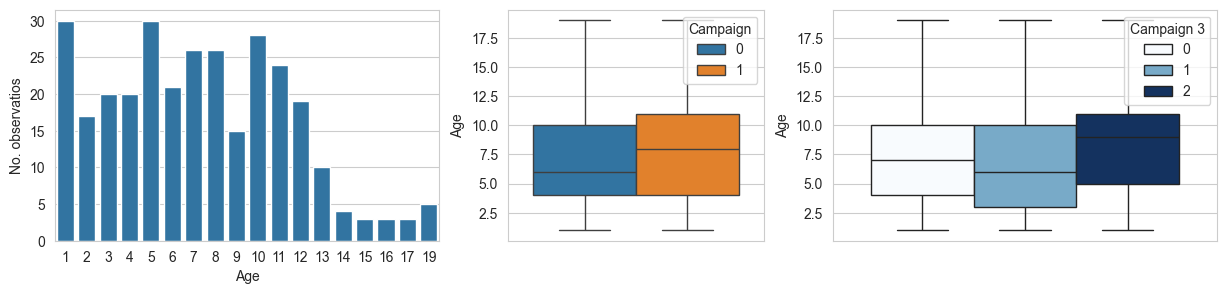

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3), gridspec_kw={'width_ratios': [3, 2, 3]})

sns.countplot(data=data_raw, x="age", ax=axs[0])
axs[0].set(ylabel="No. observatios", xlabel="Age")

sns.boxplot(data=data_raw, y="age", hue="campaign", ax=axs[1])
axs[1].set(ylabel="Age")
axs[1].legend(loc='upper right', title="Campaign")

sns.boxplot(data=data_raw, y="age", hue="campaign_3", ax=axs[2], palette="Blues")
axs[2].set(ylabel="Age")
axs[2].legend(loc='upper right', title="Campaign 3")

plt.show()

In [57]:
data_raw[["revenue_m2_22", "age"]].corr("spearman")

,revenue_m2_22,age
revenue_m2_22,1.000,0.195
age,0.195,1.000


#### 1.7.1. Age categorisation

In [58]:
data_raw.loc[data_raw["age"] == 1, "age_rang"] = 0
data_raw.loc[data_raw["age"].between(2, 5), "age_rang"] = 1
data_raw.loc[data_raw["age"].between(6, 10), "age_rang"] = 2
data_raw.loc[data_raw["age"] > 10, "age_rang"] = 3
data_raw["age_rang"] = data_raw["age_rang"].map({0: "One-year-old", 1: "New", 2: "Mature", 3: "Old"})

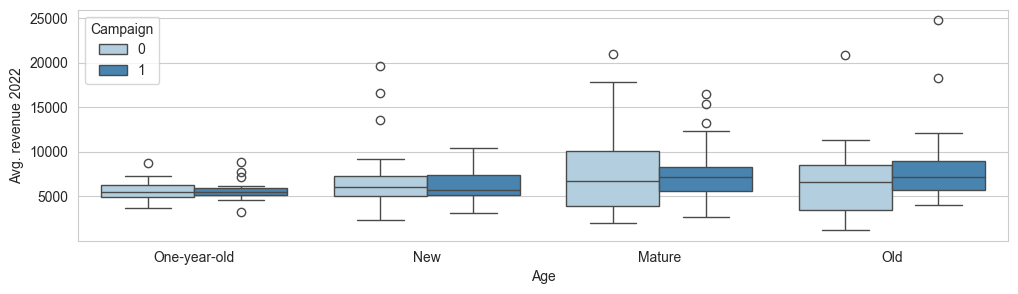

In [59]:
plt.figure(figsize=(12, 3))
ax = sns.boxplot(data=data_raw, y="revenue_m2_22", x="age_rang", hue="campaign", palette="Blues", order=["One-year-old", "New", "Mature", "Old"])
ax.set(ylabel="Avg. revenue 2022", xlabel="Age")
ax.legend(loc='upper left', title="Campaign")
plt.show()

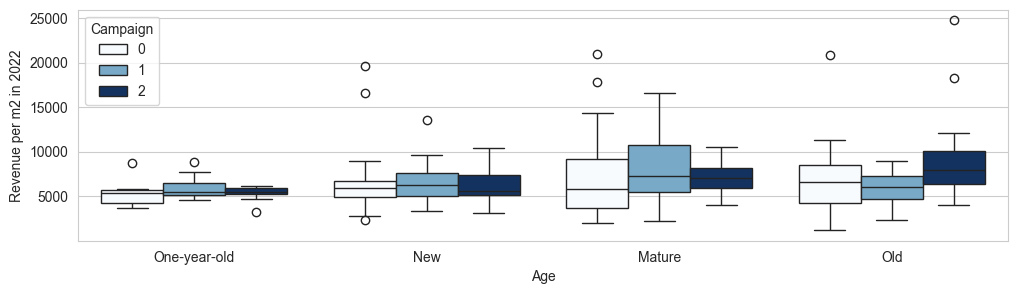

In [60]:
plt.figure(figsize=(12, 3))
ax = sns.boxplot(data=data_raw, y="revenue_m2_22", x="age_rang", hue="campaign_3", palette="Blues", order=["One-year-old", "New", "Mature", "Old"])
ax.set(ylabel="Revenue per m2 in 2022", xlabel="Age")
ax.legend(loc='upper left', title="Campaign")
plt.show()

#### 1.6.2. The influence of shop age on participation in the sale flyer campaign - the case of an ordered variable

In [61]:
freq_table = crosstab(data_raw["campaign_3"], data_raw["age_rang"])
pd.DataFrame(
    freq_table.count,
    index = freq_table.elements[0],
    columns = freq_table.elements[1],
).loc[:,["One-year-old", "New", "Mature", "Old"]]

,One-year-old,New,Mature,Old
0,6,32,42,20
1,16,32,42,20
2,8,23,32,31


In [62]:
res = chi2_contingency(freq_table.count)
res

Chi2ContingencyResult(statistic=11.378333147644177, pvalue=0.07736410518624165, dof=6, expected_freq=array([[38.15789, 28.61842, 23.35526,  9.86842],
       [41.97368, 31.48026, 25.69079, 10.85526],
       [35.86842, 26.90132, 21.95395,  9.27632]]))

#### 1.6.3. The influence of shop age on participation in the sale flyer campaign - the case of an binary variable

In [63]:
freq_table = crosstab(data_raw["campaign"], data_raw["age_rang"])
pd.DataFrame(
    freq_table.count,
    index = freq_table.elements[0],
    columns = freq_table.elements[1],
).loc[:,["One-year-old", "New", "Mature", "Old"]]

,One-year-old,New,Mature,Old
0,11,52,53,26
1,19,35,63,45


In [64]:
res = chi2_contingency(freq_table.count)
res

Chi2ContingencyResult(statistic=10.12980331819734, pvalue=0.01749438094086101, dof=3, expected_freq=array([[54.18421, 40.63816, 33.16447, 14.01316],
       [61.81579, 46.36184, 37.83553, 15.98684]]))

Since the p-value is less than 0.05, there are basis to reject H0. The results suggest that there is a relationship between the age of the store and its participation in the sale flyer campaign. Older stores are more willing to participate in the campaign.

#### 1.6.4. The impact of a sale flyer campaign on revenues for different store ages

In [65]:
for size in data_raw["age_rang"].unique():
    print("Age: ", size)
    data_tmp = data_raw[data_raw["age_rang"] == size]
    x = data_tmp[data_tmp["campaign"] == 0]["revenue_m2_22"]
    y = data_tmp[data_tmp["campaign"] == 1]["revenue_m2_22"]
    res = mannwhitneyu(x, y, alternative="less", method="exact")
    print("Average revenue of shops not participating in sale flyer campaign: ", np.mean(x))
    print("Average revenue of shops participating in sale flyer campaign:", np.mean(y))
    print("P-value: ", res.pvalue)
    print()

Age:  New
Average revenue of shops not participating in sale flyer campaign:  6481.26712600385
Average revenue of shops participating in sale flyer campaign: 6264.295947791604
P-value:  0.46741009099824027

Age:  One-year-old
Average revenue of shops not participating in sale flyer campaign:  5668.564192499024
Average revenue of shops participating in sale flyer campaign: 5695.482677456214
P-value:  0.5

Age:  Old
Average revenue of shops not participating in sale flyer campaign:  6582.019099773896
Average revenue of shops participating in sale flyer campaign: 7882.388904394287
P-value:  0.04453441173446307

Age:  Mature
Average revenue of shops not participating in sale flyer campaign:  7308.811926926353
Average revenue of shops participating in sale flyer campaign: 7285.7890445454805
P-value:  0.24843288285746085



In [66]:
selected_cols = [
    'vivodeship', 'floor_surface', 'age', 'revenue_m2_21',
       'floor_surface_rang', 'age_rang',
       'campaign', 'campaign_3', 'revenue_m2_22']

In [67]:
data = data_raw[selected_cols]
data.head()

,vivodeship,floor_surface,age,revenue_m2_21,floor_surface_rang,age_rang,campaign,campaign_3,revenue_m2_22
0,dolnośląskie,1300,4,7206.284,M,New,1,2,8042.070
1,małopolskie,1000,3,8707.300,M,New,0,1,9177.000
2,warmińsko-mazurskie,450,3,4138.039,S,New,0,0,3788.180
3,lubuskie,900,4,6017.756,M,New,0,1,4414.140
4,zachodniopomorskie,1800,2,3397.416,L,New,0,1,3378.539


In [68]:
# data.to_csv("data/final.csv")

# 2. Linear regression

In [69]:
TREATMENT = "campaign"
OUTCOME = "revenue_m2_22"
COVARIATES = [
    "revenue_m2_21",
    "floor_surface", 
    "age", 
]

In [70]:
data_ols = data.copy()

In [71]:
y = np.log(data_ols[OUTCOME])
X = data_ols[[TREATMENT] + COVARIATES]
X_stand = (X - X.mean()) / X.std()

In [72]:
reg_model = sm.OLS(y, sm.add_constant(X)).fit()
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          revenue_m2_22   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     247.7
Date:                Tue, 28 May 2024   Prob (F-statistic):           1.44e-93
Time:                        21:22:50   Log-Likelihood:                 45.011
No. Observations:                 304   AIC:                            -80.02
Df Residuals:                     299   BIC:                            -61.44
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.0641      0.039    209.155      0.000       7.988       8.140
campaign          0.1235      0.026      4.820      0.000       0.073       0.174
revenue_m2_21     0.0001      4e-06     29.401      0.000       0.000       0.000
floor_surface -2.244e-05   1.48e-05     -1.517      0.130   -5.16e-05    6.66e-06
age              -0.0117      0.003     -3.860      0.000      -0.018      -0.006
==============================================================================
Omnibus:                       37.134   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.239
Skew:                          -0.563   Prob(JB):                     1.26e-21
Kurtosis:                       5.516   Cond. No.                     2.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The parameter estimate for the "campaign" variable is 0.1235, with a 95% confidence interval of (0.073 	0.174). This means that the model predicts that if a store takes part in the store flyer campaign more than 7 times, its revenues per square meter will increase by 12.35%.

In [73]:
y = data_ols[OUTCOME]
X = data_ols[[TREATMENT] + COVARIATES]

In [74]:
reg_model = sm.OLS(y, sm.add_constant(X)).fit()
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          revenue_m2_22   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     612.6
Date:                Tue, 28 May 2024   Prob (F-statistic):          1.19e-142
Time:                        21:22:50   Log-Likelihood:                -2549.3
No. Observations:                 304   AIC:                             5109.
Df Residuals:                     299   BIC:                             5127.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1311.9241    196.009      6.693      0.000     926.191    1697.657
campaign        268.3473    130.202      2.061      0.040      12.119     524.576
revenue_m2_21     0.9564      0.020     47.038      0.000       0.916       0.996
floor_surface    -0.0215      0.075     -0.286      0.775      -0.170       0.126
age             -68.6891     15.448     -4.446      0.000     -99.090     -38.288
==============================================================================
Omnibus:                       95.213   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              407.853
Skew:                           1.256   Prob(JB):                     2.73e-89
Kurtosis:                       8.089   Cond. No.                     2.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Regression may also be used to estimate the treatment parameters when the con-
stant treatment effect assumption is relaxed, which implies that the mean treatment
effect on the treated is different than the mean treatment effect on the control.

In [75]:
data_ols["floor_surface_treatment"] = (data_ols["floor_surface"] - \
                                      data_ols["floor_surface"].mean()) * data_ols["campaign"]
data_ols["age_treatment"] = (data_ols["age"] - \
                              data_ols["age"].mean()) * data_ols["campaign"]
data_ols["revenue_m2_21_treatment"] = (data_ols["revenue_m2_21"] - \
                                        data_ols["revenue_m2_21"].mean()) * data_ols["campaign"]

In [76]:
data_ols["floor_surface_control"] = (data_ols["floor_surface"] - \
                                      data_ols["floor_surface"].mean()) * (data_ols["campaign"] - 1)
data_ols["age_control"] = (data_ols["age"] - \
                              data_ols["age"].mean()) * data_ols["campaign"]
data_ols["revenue_m2_21_control"] = (data_ols["revenue_m2_21"] - \
                                        data_ols["revenue_m2_21"].mean()) * (data_ols["campaign"] - 1)

In [77]:
COVARIATES = [
    "floor_surface", 
    "age",
    "revenue_m2_21",
]
COVARIATES_T = [
    "floor_surface_treatment",
    "age_treatment",
    "revenue_m2_21_treatment"
]
COVARIATES_C = [
    "floor_surface_control",
    "age_control",
    "revenue_m2_21_control"
]

In [78]:
y = data_ols[OUTCOME]
X = data_ols[[TREATMENT] + COVARIATES + COVARIATES_T]

In [79]:
reg_model = sm.OLS(y, sm.add_constant(X)).fit()
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          revenue_m2_22   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     354.7
Date:                Tue, 28 May 2024   Prob (F-statistic):          7.12e-140
Time:                        21:22:50   Log-Likelihood:                -2546.1
No. Observations:                 304   AIC:                             5108.
Df Residuals:                     296   BIC:                             5138.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     922.7963    271.894      3.394      0.001     387.706    1457.887
campaign                  245.7812    129.911      1.892      0.059      -9.886     501.448
floor_surface               0.1604      0.118      1.357      0.176      -0.072       0.393
age                       -78.9847     23.578     -3.350      0.001    -125.387     -32.582
revenue_m2_21               0.9948      0.027     37.124      0.000       0.942       1.048
floor_surface_treatment    -0.2998      0.153     -1.962      0.051      -0.601       0.001
age_treatment              19.7483     31.312      0.631      0.529     -41.875      81.371
revenue_m2_21_treatment    -0.0821      0.041     -1.990      0.048      -0.163      -0.001
==============================================================================
Omnibus:                       81.041   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.523
Skew:                           1.069   Prob(JB):                     7.57e-72
Kurtosis:                       7.614   Cond. No.                     3.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
reg_model.params

const                     922.796
campaign                  245.781
floor_surface               0.160
age                       -78.985
revenue_m2_21               0.995
floor_surface_treatment    -0.300
age_treatment              19.748
revenue_m2_21_treatment    -0.082
dtype: float64

In [81]:
ATE = reg_model.params.iloc[1]
print(f"ATE = {ATE} PLN/m2")

ATE = 245.78117921545225 PLN/m2


In [82]:
beta = reg_model.params.loc[COVARIATES]
beta

floor_surface     0.160
age             -78.985
revenue_m2_21     0.995
dtype: float64

In [83]:
ATT = ATE + np.sum(np.dot(data_ols[COVARIATES_T], beta)) / sum(data_ols["campaign"])
print(f"ATT = {ATT} PLN/m2")

ATT = 305.23313707644746 PLN/m2


In [84]:
ATC = ATE + np.sum(np.dot(data_ols[COVARIATES_C], beta)) / sum(data_ols["campaign"].map({1: 0, 0:1}))
print(f"ATC = {ATC} PLN/m2")

ATC = 313.6066522681375 PLN/m2


In [85]:
def bootstrap_ols(df, ATE, T, Y, X, X_T, X_C=None, metric="ATT"):
    """
    Bootstrap for calculating standard errors od ATT and ATC from OLS
    
    Args:
        ATE - parameters from OLS regression standing before treatment variable
        X_T - list of columns with (X - X.mean()) * T
        X_C - list of columns with (X - X.mean()) * (T-1) 
    """
    y_set = df[Y]
    X_set = df[[T] + X + X_T]
    reg_model = sm.OLS(y_set, sm.add_constant(X_set)).fit()
    beta = reg_model.params.loc[X]
    if metric.lower() == "att":
        res = ATE + np.sum(np.dot(df[X_T], beta)) / sum(df["campaign"])
    elif metric.lower() == "atc" and X_C:
        res = ATE + np.sum(np.dot(df[X_C], beta)) / sum(df["campaign"].map({1: 0, 0:1}))
    else:
        res = None
    return res

In [86]:
np.random.seed(0)
bootstrap_sample = 5000
atts = Parallel(n_jobs=4)(delayed(bootstrap_ols)(
    data_ols.sample(frac=1, replace=True), ATE, TREATMENT, OUTCOME, COVARIATES, COVARIATES_T, "ATT"
) for _ in range(bootstrap_sample))
atts = np.array(atts)
atts.mean()

299.86523

In [87]:
np.percentile(atts, (2.5, 97.5))

array([-117.85062,  764.11329])

In [88]:
np.random.seed(0)
bootstrap_sample = 5000
atcs = Parallel(n_jobs=4)(delayed(bootstrap_ols)(
    data_ols.sample(frac=1, replace=True), ATE, TREATMENT, OUTCOME, COVARIATES, COVARIATES_T, COVARIATES_C, "ATC"
) for _ in range(bootstrap_sample))
atcs = np.array(atcs)
atcs.mean()

308.03870

In [89]:
np.percentile(atcs, (2.5, 97.5))

array([-297.38493,  877.74894])

# 2. Logistic regression

### 2.1. Propensity score estimation

In [90]:
# we estimate a linear regression model in which
# Y - participation in the campaign and X - covariates
data_lr = data.copy()
logit_mod = LogisticRegression(random_state=2, max_iter=500).fit(
    sm.add_constant(data_lr[COVARIATES]),
    data_lr[TREATMENT]
)

In [91]:
ps = logit_mod.predict_proba(
    sm.add_constant(data_lr[COVARIATES])
)[:, 1]
data_lr["propensity_score"] = ps
data_lr["class_prob"] = np.where(
    data_lr["campaign"] == 1, 
    data_lr["propensity_score"], 
    1 - data_lr["propensity_score"]
)

In [92]:
log_reg = sm.Logit(
    data_lr[TREATMENT],
    sm.add_constant(data_lr[COVARIATES]),
).fit() 
print(log_reg.summary()) 

Optimization terminated successfully.
         Current function value: 0.630856
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               campaign   No. Observations:                  304
Model:                          Logit   Df Residuals:                      300
Method:                           MLE   Df Model:                            3
Date:                Tue, 28 May 2024   Pseudo R-squ.:                 0.08701
Time:                        21:22:54   Log-Likelihood:                -191.78
converged:                       True   LL-Null:                       -210.06
Covariance Type:            nonrobust   LLR p-value:                 5.712e-08
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.6882      0.417     -4.052      0.000      -2.505      -0.872
floor_surface     0.

### 2.2. Model diagnostics 1/2

#### **Common support**

In [93]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

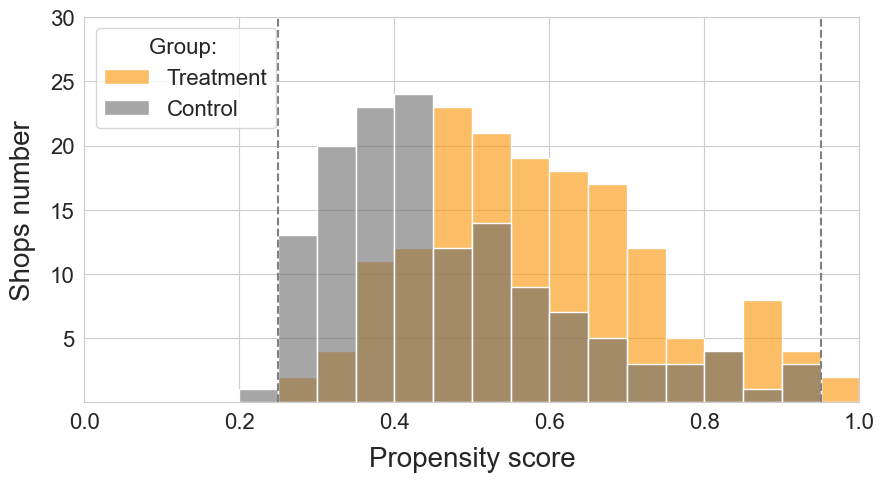

In [94]:
colors = ["#6b6b6b", "#f99100"]

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 1)
# ax0 = plt.subplot(gs[0, 0:4])
ax = plt.subplot(gs[0, 0:6])
sns.histplot(data=data_lr, x='propensity_score', 
    fill=True, hue="campaign", alpha=0.6, 
    binrange=[0,1], binwidth=0.05, palette=colors
)

ax.set_ylabel(ylabel="Shops number", labelpad=10)
ax.set_ylim(0, 30)
plt.yticks(range(5, 31, 5))

ax.set_xlabel(xlabel="Propensity score", labelpad=10)
ax.set_xlim(0, 1)
plt.xticks(np.array(range(0, 11, 2))/10) 
plt.legend(title="Group: ", labels=["Treatment", "Control"], loc="upper left");

ax.vlines(x=.25, ymin=0, ymax=30, colors="grey", linestyles="--")
ax.vlines(x=.95, ymin=0, ymax=30, colors="grey", linestyles="--")

plt.show()

In [95]:
# common support assumption
data_lr_trim = data_lr[(data_lr["propensity_score"] > .25) & (data_lr["propensity_score"] < .95)].copy()
data_lr.shape, data_lr_trim.shape

((304, 11), (301, 11))

#### **Propensity score between-group balance check**

In [96]:
results = pd.DataFrame()
N = 6
for q in range(1, N):
    for g in [0, 1]:
        ps_tmp = data_lr_trim[data_lr_trim[TREATMENT] == g]["propensity_score"]
        v1, v2 = np.quantile(ps_tmp, [(q-1)*0.2, q*0.2])
        ps_tmp = ps_tmp[(ps_tmp < v2) & (ps_tmp > v1)]
        min = ps_tmp.min()
        max = ps_tmp.max()
        avg = ps_tmp.mean()
        res_row = pd.DataFrame({
            "Quintile": [q],
            "Group": [g],
            "Min": [min],
            "Max": [max],
            "Mena": [avg]
        })
        results = pd.concat([results, res_row])
results.reset_index(drop=True)

,Quintile,Group,Min,Max,Mena
0,1,0,0.261,0.330,0.303
1,1,1,0.288,0.455,0.393
2,2,0,0.338,0.400,0.370
3,2,1,0.456,0.529,0.492
4,3,0,0.400,0.462,0.434
5,3,1,0.531,0.611,0.571
6,4,0,0.464,0.588,0.525
7,4,1,0.613,0.703,0.656
8,5,0,0.592,0.914,0.722
9,5,1,0.709,0.941,0.803


### 2.3. Inverse probability of treatment weighting

In [97]:
data_lr_trim['weight'] = np.where(
    data_lr_trim[TREATMENT] == 0, 
    1 / (1 - data_lr_trim['propensity_score']), 
    1 / data_lr_trim['propensity_score']
)
weight_t = data_lr_trim[data_lr_trim[TREATMENT] == 1]["weight"]
weight_nt = data_lr_trim[data_lr_trim[TREATMENT] == 0]["weight"]

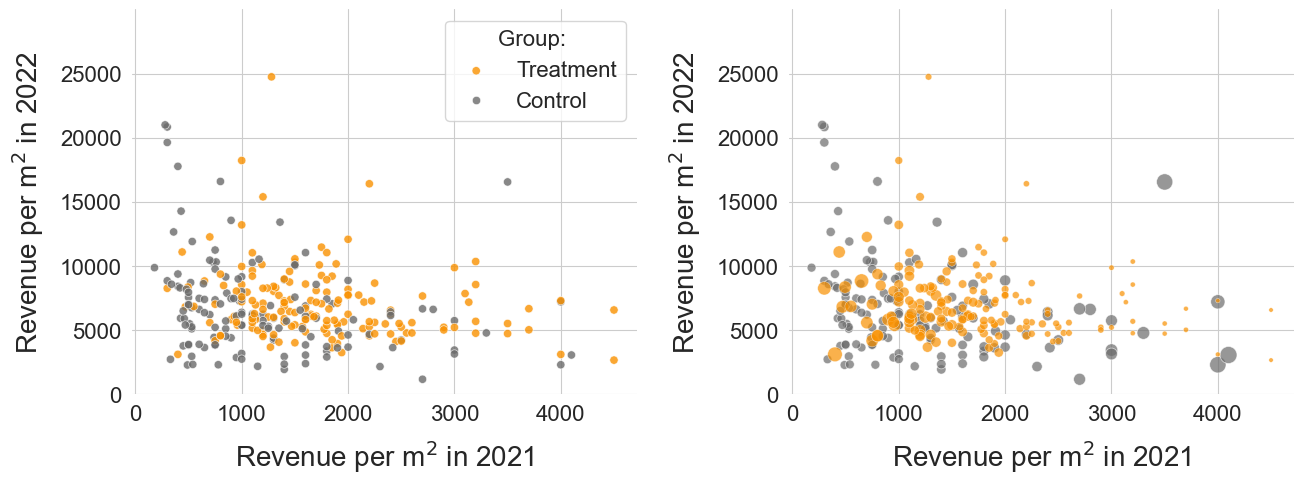

In [98]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 2, wspace=0.3)
ax0 = plt.subplot(gs[0, 0:1])
sns.scatterplot(
    data=data_lr_trim, y='revenue_m2_22', x='floor_surface', 
    hue="campaign", palette=colors, alpha=0.8, ax=ax0, sizes=100)
ax0.legend(title="Group: ", labels=["Treatment", "Control"]);
ax0.set_ylabel(ylabel="Revenue per m$^{2}$ in 2022", labelpad=10)
ax0.set_xlabel(xlabel="Revenue per m$^{2}$ in 2021", labelpad=10)
ax0.set_ylim(1, 30000)
plt.yticks(range(-0, 28000, 5000)) 

ax1 = plt.subplot(gs[0, 1:2])
sns.scatterplot(
    data=data_lr_trim[data_lr_trim["campaign"] == 0], y='revenue_m2_22', x='floor_surface', 
    color=colors[0], alpha=0.7, ax=ax1, size=weight_nt, sizes=(40, 150)
)
sns.scatterplot(
    data=data_lr_trim[data_lr_trim["campaign"] == 1], y='revenue_m2_22', x='floor_surface', 
    color=colors[1], alpha=0.7, ax=ax1, size=weight_t, sizes=(10, 110)
)
ax1.legend().set_visible(False)
ax1.set_ylabel(ylabel="Revenue per m$^{2}$ in 2022", labelpad=10)
ax1.set_xlabel(xlabel="Revenue per m$^{2}$ in 2021", labelpad=10)
ax1.set_ylim(1, 30000)
plt.yticks(range(-0, 28000, 5000)) 
# ax1.set_xlim(1, 28000)
# ax1.set_xticks(range(5000, 28000, 5000)) 

for ax in [ax1, ax0]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.show()

### 2.4. Model diagnostics 2/2

#### **Distribution plot**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


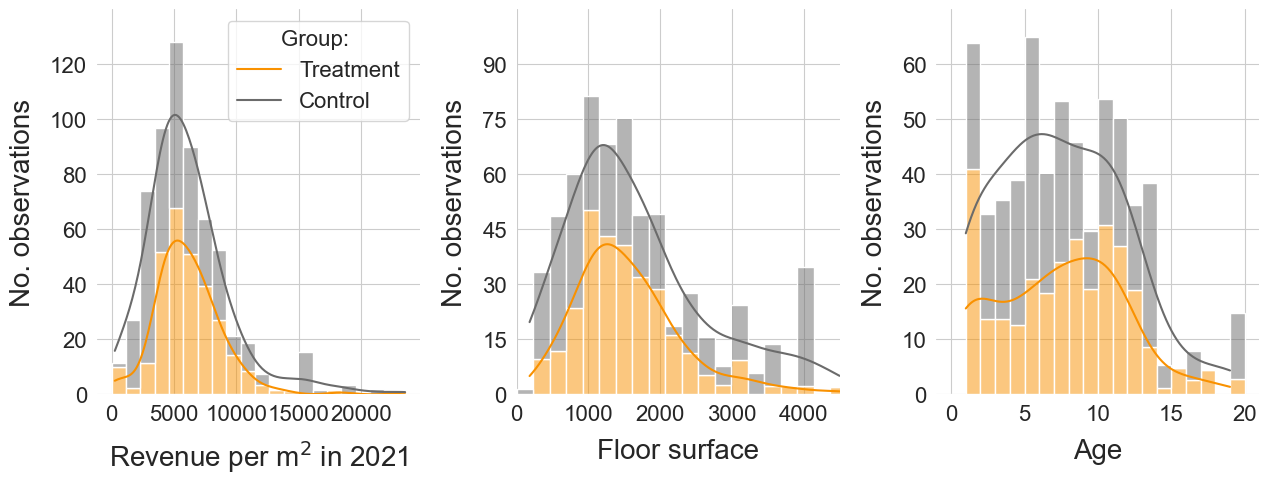

In [99]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.3)
ax0 = plt.subplot(gs[0, 0:1])
sns.histplot(
    data=data_lr_trim, x='revenue_m2_21', hue="campaign", weights='weight', ax=ax0,
    multiple='stack', kde=True, palette=colors, bins=20, binrange=[0, 23000])
ax0.set_ylabel(ylabel="No. observations", labelpad=10)
ax0.set_xlabel(xlabel="Revenue per m$^{2}$ in 2021", labelpad=10)
ax0.set_ylim(1, 140)
plt.yticks(range(0, 130, 20)) 
# ax0.set_xlim(1, 24000)
ax0.set_xticks(range(0, 24000, 5000)) 
ax0.legend(title="Group: ", labels=["Treatment", "Control"]);

ax1 = plt.subplot(gs[0, 1:2])
sns.histplot(
    data=data_lr_trim, x='floor_surface', hue="campaign", weights='weight', ax=ax1,
    multiple='stack', kde=True, palette=colors, bins=20, binrange=[0, 4600])
ax1.set_ylabel(ylabel="No. observations", labelpad=10)
ax1.set_xlabel(xlabel="Floor surface", labelpad=10)
ax1.set_ylim(1, 105)
ax1.set_yticks(range(0, 100, 15)) 
ax1.set_xlim(1, 4500)
ax1.set_xticks(range(0, 4600, 1000)) 
ax1.legend().set_visible(False)

ax2 = plt.subplot(gs[0, 2:3])
sns.histplot(
    data=data_lr_trim, x='age', hue="campaign", weights='weight', ax=ax2,
    multiple='stack', kde=True, palette=colors, bins=20, binrange=[0, 20])
ax2.set_ylabel(ylabel="No. observations", labelpad=10)
ax2.set_xlabel(xlabel="Age", labelpad=10)
ax2.set_ylim(1, 70)
ax2.set_yticks(range(0, 70, 10)) 
# ax2.set_xlim(1, 4800)
ax2.set_xticks(range(0, 23, 5)) 
ax2.legend().set_visible(False)

for ax in [ax0, ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.show()

In [100]:
# common support
data_lr_trim = data_lr_trim[(data_lr_trim["propensity_score"] > .25) & (data_lr_trim["propensity_score"] < .9)]
data_lr.shape, data_lr_trim.shape

((304, 11), (294, 12))

In [101]:
# IPTW
data_lr_trim['weight'] = np.where(
    data_lr_trim[TREATMENT] == 0, 
    1 / (1 - data_lr_trim['propensity_score']), 
    1 / data_lr_trim['propensity_score']
)
weight_t = data_lr_trim[data_lr_trim[TREATMENT] == 1]["weight"]
weight_nt = data_lr_trim[data_lr_trim[TREATMENT] == 0]["weight"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


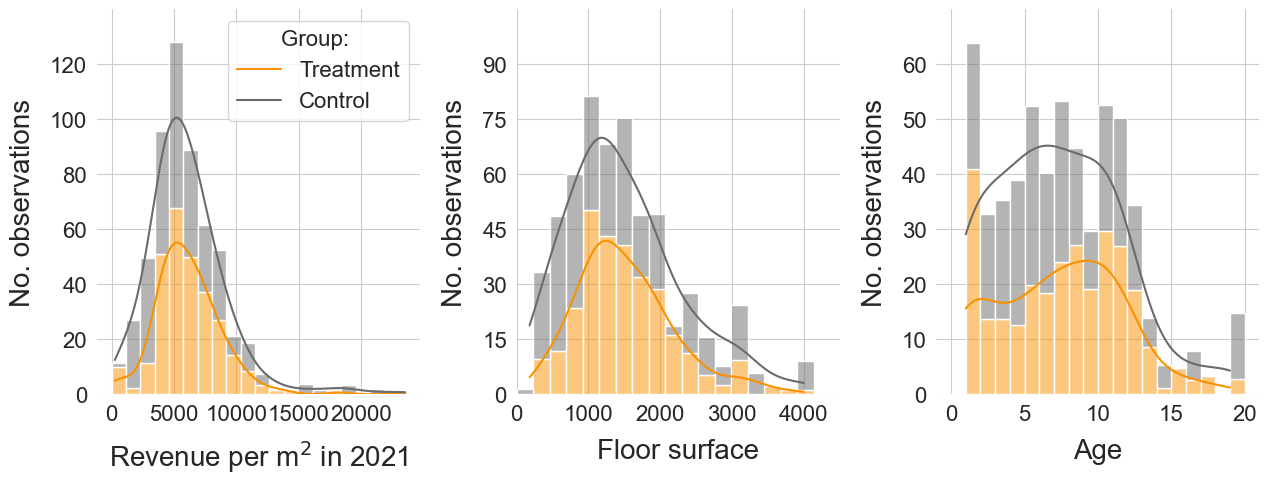

In [102]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.3)
ax0 = plt.subplot(gs[0, 0:1])
sns.histplot(
    data=data_lr_trim, x='revenue_m2_21', hue="campaign", weights='weight', ax=ax0,
    multiple='stack', kde=True, palette=colors, bins=20, binrange=[0, 23000])
ax0.set_ylabel(ylabel="No. observations", labelpad=10)
ax0.set_xlabel(xlabel="Revenue per m$^{2}$ in 2021", labelpad=10)
ax0.set_ylim(1, 140)
plt.yticks(range(0, 130, 20)) 
# ax0.set_xlim(1, 24000)
ax0.set_xticks(range(0, 24000, 5000)) 
ax0.legend(title="Group: ", labels=["Treatment", "Control"]);

ax1 = plt.subplot(gs[0, 1:2])
sns.histplot(
    data=data_lr_trim, x='floor_surface', hue="campaign", weights='weight', ax=ax1,
    multiple='stack', kde=True, palette=colors, bins=20, binrange=[0, 4600])
ax1.set_ylabel(ylabel="No. observations", labelpad=10)
ax1.set_xlabel(xlabel="Floor surface", labelpad=10)
ax1.set_ylim(1, 105)
ax1.set_yticks(range(0, 100, 15)) 
ax1.set_xlim(1, 4500)
ax1.set_xticks(range(0, 4600, 1000)) 
ax1.legend().set_visible(False)

ax2 = plt.subplot(gs[0, 2:3])
sns.histplot(
    data=data_lr_trim, x='age', hue="campaign", weights='weight', ax=ax2,
    multiple='stack', kde=True, palette=colors, bins=20, binrange=[0, 20])
ax2.set_ylabel(ylabel="No. observations", labelpad=10)
ax2.set_xlabel(xlabel="Age", labelpad=10)
ax2.set_ylim(1, 70)
ax2.set_yticks(range(0, 70, 10)) 
# ax2.set_xlim(1, 4800)
ax2.set_xticks(range(0, 23, 5)) 
ax2.legend().set_visible(False)

for ax in [ax0, ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.show()

#### **Standardized means difference**

In [103]:
def weighted_smd(treatment_x, control_x, treatment_weights, control_weights):
    """
    Implements standardized mean difference (SMD) that is a measure to assess 
    the balance in the marginal distributions of covariates.
    """
    treatment_mean = np.average(treatment_x, weights=treatment_weights)
    control_mean = np.average(control_x, weights=control_weights)

    treatment_var = np.average((treatment_x - treatment_mean)**2, weights=treatment_weights)
    control_var = np.average((control_x - control_mean)**2, weights=control_weights)

    SMD = (treatment_mean - control_mean) / np.sqrt((treatment_var + control_var) / 2)
    return SMD

def average_smd(smd_list):
    """
    Computes average absolute standardized mean difference of all covariates
    """
    return np.mean(np.abs(smd_list))

def run_smd(df, X, T, W):
    """
    Calculates SMD; used to produce confidence intervals of SMD
    """
    treatment_x = df[df[T] == 1][cov]
    control_x = df[df[T] == 0][cov]
    treatment_weights = df[df[T] == 1][W]
    control_weights = df[df[T] == 0][W]
    smd = weighted_smd(treatment_x, control_x, treatment_weights, control_weights)
    return smd

In [104]:
smd_list = []
for cov in COVARIATES:
    treatment_x = data_lr_trim[data_lr_trim[TREATMENT] == 1][cov]
    control_x = data_lr_trim[data_lr_trim[TREATMENT] == 0][cov]
    treatment_weights = data_lr_trim[data_lr_trim[TREATMENT] == 1]["weight"]
    control_weights = data_lr_trim[data_lr_trim[TREATMENT] == 0]["weight"]

    np.random.seed(88)
    bootstrap_sample = 1000
    smds = Parallel(n_jobs=4)(delayed(run_smd)(
        data_lr_trim.sample(frac=1, replace=True), cov, TREATMENT, "weight"
    ) for _ in range(bootstrap_sample))
    smds = np.array(smds)
    ci_l, ci_u = np.quantile(smds, [0.025, 0.975])
    
    smd = {
        "Variable": cov,
        "Mean_treat_before": treatment_x.mean(),
        "Mean_cont_before": control_x.mean(),
        "SMD_before": weighted_smd(treatment_x, control_x, [1] * len(treatment_weights), [1] * len(control_weights)),
        "Mean_treat": np.average(treatment_x, weights=treatment_weights),
        "Mean_cont": np.average(control_x, weights=control_weights),
        "SMD": weighted_smd(treatment_x, control_x, treatment_weights, control_weights),
        # "SMD_lower": ci_l,
        # "SMD_upper": ci_u
    }
    smd_list.append(smd)
smd_df = pd.DataFrame(smd_list)
smd_df

,Variable,Mean_treat_before,Mean_cont_before,SMD_before,Mean_treat,Mean_cont,SMD
0,floor_surface,1672.827,1160.616,0.713,1513.112,1472.783,0.050
1,age,7.564,6.696,0.211,7.288,7.154,0.031
2,revenue_m2_21,6330.991,6197.199,0.041,6185.534,5968.681,0.069


### 2.5. Average Treatment Effect estimation

In [105]:
def run_ate(df, X, T, Y, metric="ATE"):
    """Calculates ATE, ATT or ATC; used to produce confidence intervals"""
    X_set = sm.add_constant(df[X])
    logit_mod = LogisticRegression(random_state=2, max_iter=500).fit(
        X_set,
        df[TREATMENT]
    )
    ps = logit_mod.predict_proba(X_set)[:, 1]
    if metric.lower() == "ate":
        weight = (df[T] - ps) / (ps * (1 - ps))
    elif metric.lower() == "att":
        weight = (df[T] - ps) / (1 - ps)
    elif metric.lower() == "atc":
        weight = (df[T] - ps) / ps
    else:
        return None
    return np.mean(weight * df[Y])

np.random.seed(0)
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ate)(
    data_lr_trim.sample(frac=1, replace=True), COVARIATES, TREATMENT, OUTCOME
) for _ in range(bootstrap_sample))
ates = np.array(ates)

atts = Parallel(n_jobs=4)(delayed(run_ate)(
    data_lr_trim.sample(frac=1, replace=True), COVARIATES, TREATMENT, OUTCOME, "ATT"
) for _ in range(bootstrap_sample))
atts = np.array(atts)

atcs = Parallel(n_jobs=4)(delayed(run_ate)(
    data_lr_trim.sample(frac=1, replace=True), COVARIATES, TREATMENT, OUTCOME, "ATC"
) for _ in range(bootstrap_sample))
atcs = np.array(atcs)

#### **ATE**

In [106]:
N = len(data_lr_trim)
y1 = sum(data_lr_trim.query("campaign==1")["revenue_m2_22"] * weight_t) / N
y0 = sum(data_lr_trim.query("campaign==0")["revenue_m2_22"] * weight_nt) / N

ate = y1 - y0
print("ATE:", round(ate, 3), "PLN")
print(f"Confidence interval: ({np.percentile(ates, 2.5)}; {np.percentile(ates, 97.5)})")

ATE: 407.689 PLN
Confidence interval: (-1321.0550422020392; 502.3331486065068)


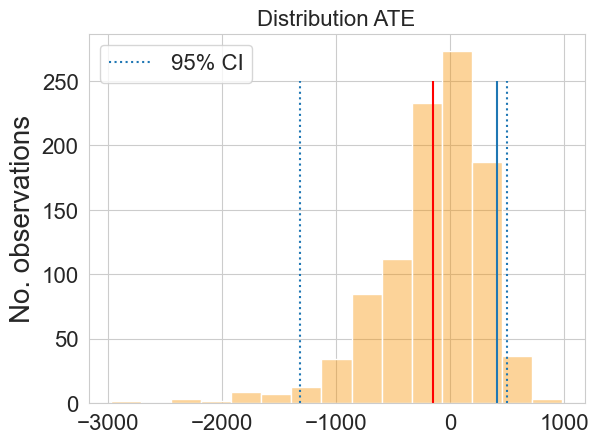

In [107]:
sns.histplot(ates, kde=False, alpha=0.4, bins=15, color=colors[1])
plt.vlines(np.percentile(ates, 2.5), 0, 250, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 250, linestyles="dotted", label="95% CI")
plt.vlines(x=ate, ymin=0, ymax=250)
plt.vlines(x=ates.mean(), ymin=0, ymax=250, colors="red")
plt.ylabel("No. observations")
plt.title("Distribution ATE")
plt.legend();

##### **ATT**

In [108]:
data_lr_trim["weights_att"] = (data_lr_trim[TREATMENT] - \
                               data_lr_trim["propensity_score"]) / (1 - data_lr_trim["propensity_score"])
att = np.sum(data_lr_trim["weights_att"] * data_lr_trim['revenue_m2_22']) / N
print("ATT:", round(att, 3), "PLN")
print(f"Confidence interval: ({np.percentile(atts, 2.5)}; {np.percentile(atts, 97.5)})")

ATT: 432.662 PLN
Confidence interval: (-960.9809083544081; 443.64853033083045)


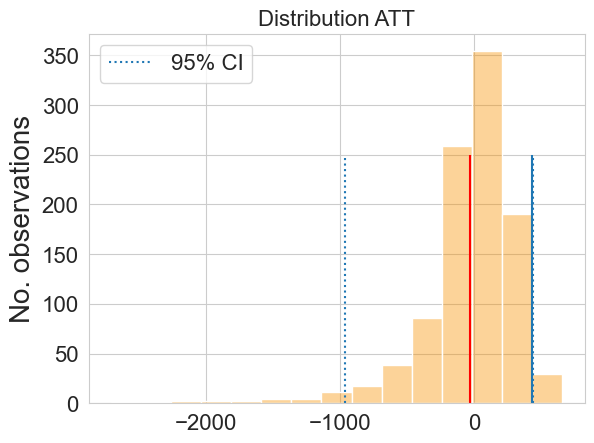

In [109]:
sns.histplot(atts, kde=False, alpha=0.4, bins=15, color=colors[1])
plt.vlines(np.percentile(atts, 2.5), 0, 250, linestyles="dotted")
plt.vlines(np.percentile(atts, 97.5), 0, 250, linestyles="dotted", label="95% CI")
plt.vlines(x=att, ymin=0, ymax=250)
plt.vlines(x=atts.mean(), ymin=0, ymax=250, colors="red")
plt.ylabel("No. observations")
plt.title("Distribution ATT")
plt.legend();

#### **ATC**

In [110]:
data_lr_trim["weights_atc"] = (data_lr_trim[TREATMENT] - \
                               data_lr_trim["propensity_score"]) / data_lr_trim["propensity_score"]
atc = np.sum(data_lr_trim["weights_atc"] * data_lr_trim['revenue_m2_22']) / N
print("ATC:", round(atc, 2), "PLN")
print(f"Confidence interval: ({np.percentile(atcs, 2.5)}; {np.percentile(atcs, 97.5)})")

ATC: -24.97 PLN
Confidence interval: (-467.09325129831996; 169.5999380163688)


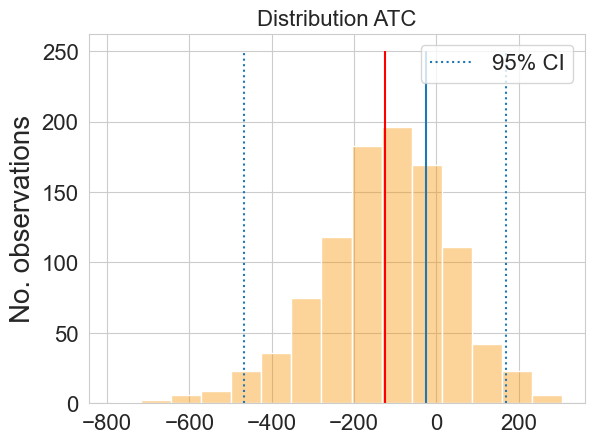

In [111]:
sns.histplot(atcs, kde=False, alpha=0.4, bins=15, color=colors[1])
plt.vlines(np.percentile(atcs, 2.5), 0, 250, linestyles="dotted")
plt.vlines(np.percentile(atcs, 97.5), 0, 250, linestyles="dotted", label="95% CI")
plt.vlines(x=atc, ymin=0, ymax=250)
plt.vlines(x=atcs.mean(), ymin=0, ymax=250, colors="red")
plt.ylabel("No. observations")
plt.title("Distribution ATC")
plt.legend();

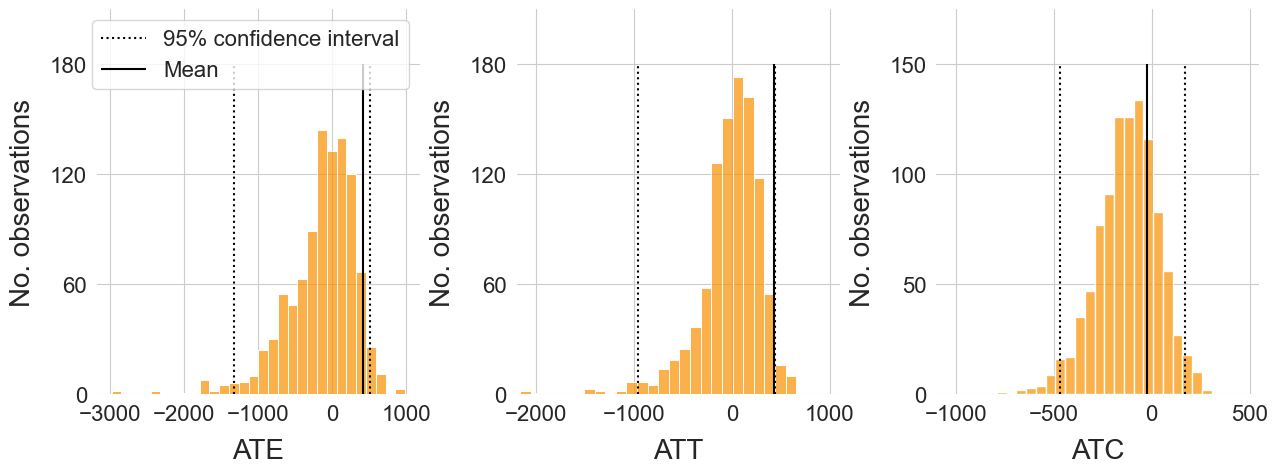

In [112]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.3)
ax0 = plt.subplot(gs[0, 0:1])
sns.histplot(
    ates, ax=ax0, color=colors[1], bins=30, alpha=0.7
)
ax0.set_ylabel(ylabel="No. observations", labelpad=10)
ax0.set_xlabel(xlabel="ATE", labelpad=10)
ax0.set_ylim(1, 210)
ax0.set_yticks(range(0, 200, 60)) 
ax1.set_xlim(-3200, 1100)
ax0.set_xticks(range(-3000, 1500, 1000)) 
plt.vlines(np.percentile(ates, 2.5), 0, 180, linestyles="dotted", color="black")
plt.vlines(np.percentile(ates, 97.5), 0, 180, linestyles="dotted", color="black", label="95% confidence interval")
# plt.vlines(x=ates.mean(), ymin=0, ymax=180, colors="black", label="Mean")
plt.vlines(x=ate, ymin=0, ymax=180, colors="black", label="Mean")
plt.legend();

# ax0.text(np.percentile(ates, 2.5)-400, 155, round(np.percentile(ates, 2.5), 3))

ax1 = plt.subplot(gs[0, 1:2])
sns.histplot(
    atts, ax=ax1, color=colors[1], bins=31, alpha=0.7
)
ax1.set_ylabel(ylabel="No. observations", labelpad=10)
ax1.set_xlabel(xlabel="ATT", labelpad=10)
ax1.set_ylim(1, 210)
ax1.set_yticks(range(0, 200, 60)) 
ax1.set_xlim(-2200, 1100)
ax1.set_xticks(range(-2000, 1100, 1000)) 
plt.vlines(np.percentile(atts, 2.5), 0, 180, linestyles="dotted", color="black")
plt.vlines(np.percentile(atts, 97.5), 0, 180, linestyles="dotted", color="black")
# plt.vlines(x=atts.mean(), ymin=0, ymax=180, colors="black")
plt.vlines(x=att, ymin=0, ymax=180, colors="black")


ax2 = plt.subplot(gs[0, 2:3])
sns.histplot(
    atcs, ax=ax2, color=colors[1], bins=22, alpha=0.7
)
ax2.set_ylabel(ylabel="No. observations", labelpad=10)
ax2.set_xlabel(xlabel="ATC", labelpad=10)
ax2.set_ylim(1, 175)
ax2.set_yticks(range(0, 160, 50)) 
ax2.set_xlim(-1100, 550)
ax2.set_xticks(range(-1000, 600, 500)) 
plt.vlines(np.percentile(atcs, 2.5), 0, 150, linestyles="dotted", color="black")
plt.vlines(np.percentile(atcs, 97.5), 0, 150, linestyles="dotted", color="black")
# plt.vlines(x=atcs.mean(), ymin=0, ymax=150, colors="black", label="Mean")
plt.vlines(x=atc, ymin=0, ymax=150, colors="black", label="Mean")


for ax in [ax0, ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.show()

### 2.6. Propensity Score matching

#### **PS matching**

In [113]:
data_lr_trim = data_lr_trim[[
    'floor_surface', 'age', 'revenue_m2_21', 'campaign',
    'revenue_m2_22', 'propensity_score', 'class_prob'
]]

In [114]:
treated_df = data_lr_trim.query("campaign == 1")
untreated_df = data_lr_trim.query("campaign == 0")

In [115]:
treated_pairs = pd.DataFrame()
for i, row in treated_df.iterrows():
    match = (np.abs(untreated_df["propensity_score"] - row["propensity_score"])).idxmin()
    match_df = untreated_df.loc[[match]].reset_index()
    cols = [c + "_match" for c in match_df.columns]
    match_df.columns = cols
    df = pd.concat([treated_df.loc[[i]].reset_index(), match_df], axis=1)
    treated_pairs = pd.concat([treated_pairs, df], axis=0)

treated_pairs = treated_pairs.reset_index(drop=True)

In [116]:
untreated_pairs = pd.DataFrame()
for i, row in untreated_df.iterrows():
    match = (np.abs(treated_df["propensity_score"] - row["propensity_score"])).idxmin()
    match_df = treated_df.loc[[match]].reset_index()
    cols = [c + "_match" for c in match_df.columns]
    match_df.columns = cols
    df = pd.concat([untreated_df.loc[[i]].reset_index(), match_df], axis=1)
    untreated_pairs = pd.concat([untreated_pairs, df], axis=0)

untreated_pairs = untreated_pairs.reset_index(drop=True)

In [117]:
matched_df = pd.concat([untreated_pairs, treated_pairs])
matched_df

,index,floor_surface,age,revenue_m2_21,campaign,revenue_m2_22,propensity_score,class_prob,index_match,floor_surface_match,age_match,revenue_m2_21_match,campaign_match,revenue_m2_22_match,propensity_score_match,class_prob_match
0,1,1000,3,8707.300,0,9177.000,0.434,0.566,273,1300,1,4170.108,1,4656.829,0.428,0.428
1,2,450,3,4138.039,0,3788.180,0.271,0.729,200,400,7,3312.610,1,3127.140,0.276,0.276
2,3,900,4,6017.756,0,4414.140,0.386,0.614,228,750,7,7184.622,1,7036.871,0.389,0.389
3,4,1800,2,3397.416,0,3378.539,0.536,0.464,202,1400,11,5240.328,1,5911.744,0.534,0.534
4,5,980,3,6256.776,0,7282.717,0.399,0.601,42,1200,1,3368.938,1,4995.973,0.396,0.396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,322,2600,4,5523.741,1,5598.187,0.735,0.735,192,2000,19,8514.509,0,8887.190,0.744,0.256
152,327,2600,4,4624.204,1,4795.048,0.726,0.726,192,2000,19,8514.509,0,8887.190,0.744,0.256
153,331,2220,10,6917.862,1,7292.481,0.716,0.716,286,2400,5,5683.168,0,6157.030,0.706,0.294
154,334,2000,10,7157.342,1,7756.377,0.677,0.677,106,1700,19,8014.503,0,8574.870,0.684,0.316


#### **Model diagnostics**

In [118]:
def smd(treatment_x, control_x):
    """
    Implements standardized mean difference (SMD) that is a measure to assess 
    the balance in the marginal distributions of covariates.
    """
    treatment_mean = np.average(treatment_x)
    control_mean = np.average(control_x)

    treatment_var = np.average((treatment_x - treatment_mean)**2)
    control_var = np.average((control_x - control_mean)**2)

    SMD = (treatment_mean - control_mean) / np.sqrt((treatment_var + control_var) / 2)
    return SMD

In [119]:
smd_list = []
for cov in COVARIATES:
    treatment_x = treated_pairs[cov]
    treatment_x_matches = treated_pairs[cov + "_match"]
    control_x = untreated_pairs[cov]
    control_x_matches = untreated_pairs[cov + "_match"]
    smd_dict = {
        "Variable": cov,
        "Mean_treatment": treatment_x.mean(),
        # "SMD_before": smd(treatment_x, control_x),
        "Mean_control": control_x.mean(),
        
        "Mean_treatment_matches": treatment_x_matches.mean(),
        "Mean_control_matches": control_x_matches.mean(),
        
        "SMD_treatment": smd(treatment_x, treatment_x_matches),
        "SMD_control": smd(control_x, control_x_matches),
    }
    smd_list.append(smd_dict)
smd_df = pd.DataFrame(smd_list)
smd_df

,Variable,Mean_treatment,Mean_control,Mean_treatment_matches,Mean_control_matches,SMD_treatment,SMD_control
0,floor_surface,1672.827,1160.616,1637.763,1179.746,0.044,-0.027
1,age,7.564,6.696,7.724,7.029,-0.036,-0.084
2,revenue_m2_21,6330.991,6197.199,6876.692,5700.236,-0.137,0.173


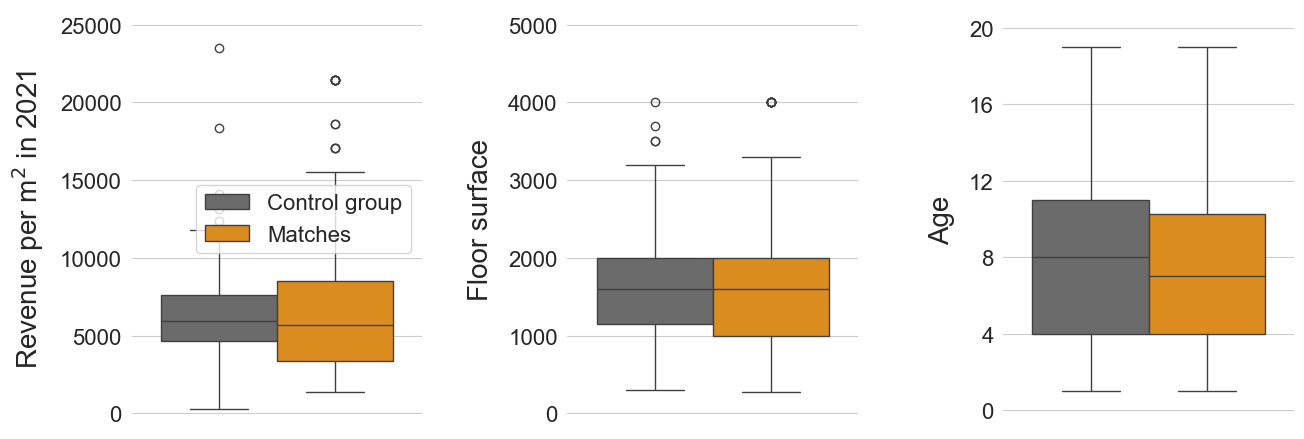

In [120]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.5, top=0.95)

treated_pairs_tmp = pd.melt(treated_pairs[["revenue_m2_21", "revenue_m2_21_match", "campaign"]], id_vars=["campaign"])
treated_pairs_tmp["variable"] = treated_pairs_tmp["variable"].map({'revenue_m2_21': 'Control group', 'revenue_m2_21_match': 'Matches'})
treated_pairs_tmp

ax0 = plt.subplot(gs[0, 0])
sns.boxplot(
    data=treated_pairs_tmp, y='value',
    palette=colors, hue="variable", ax=ax0
)
ax0.set_ylabel(ylabel="Revenue per m$^{2}$ in 2021", labelpad=10)
ax0.set_ylim(-1000, 26000)
ax0.set_yticks(range(0, 26000, 5000)) 
ax0.legend_.set_title(None)

treated_pairs_tmp = pd.melt(treated_pairs[["floor_surface", "floor_surface_match", "campaign"]], id_vars=["campaign"])
treated_pairs_tmp["variable"] = treated_pairs_tmp["variable"].map({'floor_surface': 'Control group', 'floor_surface_match': 'Matches'})
treated_pairs_tmp

ax1 = plt.subplot(gs[0, 1])
sns.boxplot(
    data=treated_pairs_tmp, y='value',
    palette=colors, hue="variable", ax=ax1
)
ax1.legend_.set_title(None)
ax1.set_ylabel(ylabel="Floor surface", labelpad=10)
ax1.legend().set_visible(False)
ax1.set_ylim(-200, 5200)
ax1.set_yticks(range(0, 6000, 1000)) 

treated_pairs_tmp = pd.melt(treated_pairs[["age", "age_match", "campaign"]], id_vars=["campaign"])
treated_pairs_tmp["variable"] = treated_pairs_tmp["variable"].map({'age': 'Control group', 'age_match': 'Matches'})
treated_pairs_tmp

ax2 = plt.subplot(gs[0, 2])
sns.boxplot(
    data=treated_pairs_tmp, y='value',
    palette=colors, hue="variable", ax=ax2
)
ax2.set_ylabel(ylabel="Age", labelpad=10)
ax2.legend().set_visible(False)
ax2.set_ylim(-1, 21)
ax2.set_yticks(range(0, 22, 4)) 

for ax in [ax0, ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.show()

In [121]:
cm = CausalModel(
    Y=data_lr_trim["revenue_m2_22"].values, 
    D=data_lr_trim["campaign"].values, 
    X=data_lr_trim[["propensity_score"]].values
)

cm.est_via_matching(matches=1)
print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   -269.333    728.285     -0.370      0.712  -1696.771   1158.105
           ATC     13.242   1032.527      0.013      0.990  -2010.510   2036.994
           ATT   -519.303    718.232     -0.723      0.470  -1927.037    888.431



In [122]:
np.mean(treated_pairs["revenue_m2_22"] - treated_pairs["revenue_m2_22_match"])

-519.30269

In [123]:
np.mean(untreated_pairs["revenue_m2_22_match"] - untreated_pairs["revenue_m2_22"])

13.24163

In [124]:
np.mean(
    (2 * matched_df["campaign"] - 1) * matched_df["revenue_m2_22"] + \
    (1 - 2 * matched_df["campaign"]) * matched_df["revenue_m2_22_match"]
)

-269.33291

## 3. Gradient Boosting

### 3.1. Propensity Score estimation

The steps performed in previous section were repeated here for GBM model

In [125]:
data_gb = data.copy()

In [126]:
def weighted_smd(treatment_x, control_x, treatment_weights, control_weights):
    """
    Implements standardized mean difference (SMD) that is a measure to assess 
    the balance in the marginal distributions of covariates.
    """
    treatment_mean = np.average(treatment_x, weights=treatment_weights)
    control_mean = np.average(control_x, weights=control_weights)

    treatment_var = np.average((treatment_x - treatment_mean)**2, weights=treatment_weights)
    control_var = np.average((control_x - control_mean)**2, weights=control_weights)

    SMD = (treatment_mean - control_mean) / np.sqrt((treatment_var + control_var) / 2)
    return SMD

def average_smd(smd_list, weights=None):
    """
    Computes average absolute standardized mean difference of all covariates
    """
    if weights is None:
        weights = [1] * len(smd_list)
    return np.average(np.abs(smd_list), weights=weights)

def get_gbm_grid(n_estimators, learning_rate, subsample, max_depth):
    keys = ["n_estimators", "learning_rate", "subsample", "max_depth"]
    vals = list(itertools.product(
        *[n_estimators, learning_rate, subsample, max_depth]
    ))
    res = [dict(zip(keys, vals[i])) for i in range(len(vals))]
    return res

def gbm_tunning(df, treatment_col, covariates_cols, params_grid, cov_weights=None, verbose=True):
    """Looks for GBM hiperparameters resulting in the lowest SMD"""
    results = pd.DataFrame()
    for params in params_grid:
        tmp_res = pd.DataFrame(params, index=[0])
        tmp_df = df.copy()
        gb_mod = GradientBoostingClassifier(
            **params, random_state=0
        ).fit(
            tmp_df[covariates_cols],
            tmp_df[treatment_col]
        )
        ps = gb_mod.predict_proba(tmp_df[covariates_cols])[:, 1]
        tmp_df["propensity_score"] = ps
        tmp_df["class_prob"] = np.where(
        tmp_df[TREATMENT] == 0, 
            (1 - tmp_df["propensity_score"]), 
            tmp_df["propensity_score"]
        )
        tmp_df = tmp_df[(tmp_df["class_prob"] <= 0.9) & (tmp_df["class_prob"] >= 0.1)]
        tmp_df["weight"] = np.where(
        tmp_df[TREATMENT] == 0, 
            1/ (1 - tmp_df["propensity_score"]), 
            1 / tmp_df["propensity_score"]
        )
        smd_list = []
        for cov in covariates_cols:
            treatment_x = tmp_df[tmp_df[treatment_col] == 1][cov]
            control_x = tmp_df[tmp_df[treatment_col] == 0][cov]
            treatment_weights = tmp_df[tmp_df[treatment_col] == 1]["weight"]
            control_weights = tmp_df[tmp_df[treatment_col] == 0]["weight"]
            smd = weighted_smd(treatment_x, control_x, treatment_weights, control_weights)
            smd_list.append(smd)
        avg_smd = average_smd(smd_list, weights=cov_weights)
        tmp_res["SMD"] = [avg_smd]
        results = pd.concat([results, tmp_res], axis=0)
        if verbose: print(f"Current parameters:{params}\nCurrent SMD: {avg_smd}")
    return results

In [127]:
params_grid = get_gbm_grid(
    # n_estimators = range(500, 4200, 200),
    n_estimators = range(200, 4200, 100),
    # learning_rate = [0.0001, 0.0005, 0.001, 0.005, 0.01], 
    learning_rate = [0.0001, 0.0005, 0.001, 0.005], 
    subsample = [0.5, 0.7, 1.0], 
    max_depth = [1, 2, 3]
)

In [128]:
# results = gbm_tunning(
#     data_gb, TREATMENT, COVARIATES, params_grid
# )
# results.to_csv("data/GMB_tunning_with_trim_3.csv", index=False)

In [129]:
# results = gbm_tunning(
#     data_gb, TREATMENT, COVARIATES, params_grid
# )
# results.to_csv("data/GMB_tunning_with_trim.csv", index=False)
# results = pd.read_csv("data/GMB_tunning_with_trim_2.csv")
results = pd.read_csv("data/GMB_tunning_with_trim_3.csv")
results[results["max_depth"] == 1].sort_values("SMD", ascending=True).head(20)
# results[(results["max_depth"] == 1) & (results["learning_rate"] < 0.005)].sort_values("SMD", ascending=True).head(20)

,n_estimators,learning_rate,subsample,max_depth,SMD
1431,4100,0.005,0.500,1,0.061
1146,3300,0.005,0.700,1,0.061
1182,3400,0.005,0.700,1,0.062
822,2400,0.005,0.700,1,0.063
786,2300,0.005,0.700,1,0.064
1110,3200,0.005,0.700,1,0.064
714,2100,0.005,0.700,1,0.064
750,2200,0.005,0.700,1,0.064
966,2800,0.005,0.700,1,0.066
1359,3900,0.005,0.500,1,0.066


In [130]:
# 243
gb_mod = GradientBoostingClassifier(
    **params_grid[1146], random_state=0
).fit(
    data_gb[COVARIATES],
    data_gb[TREATMENT]
)

In [131]:
ps = gb_mod.predict_proba(
    data_gb[COVARIATES]
)[:, 1]
data_gb["propensity_score"] = ps
data_gb["class_prob"] = np.where(
    data_gb["campaign"] == 1, 
    data_gb["propensity_score"], 
    1 - data_gb["propensity_score"]
)

### 2.2. Model diagnostics 1/2

#### **Common support**

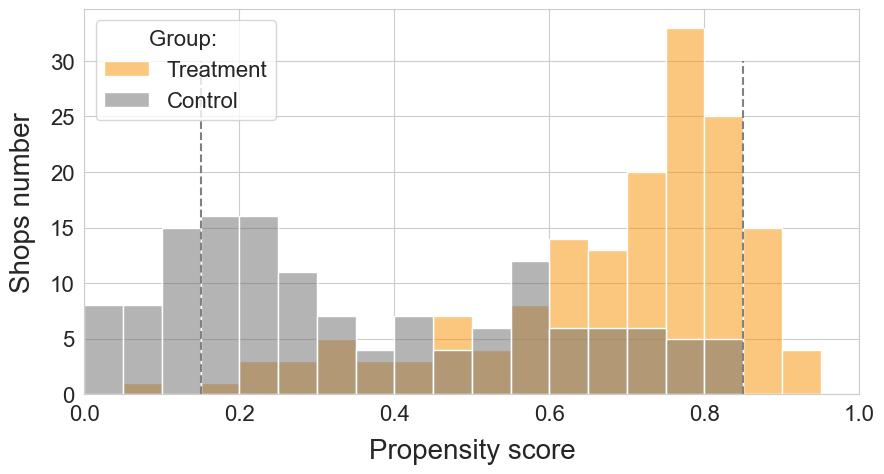

In [132]:
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 1)
# ax0 = plt.subplot(gs[0, 0:4])
ax = plt.subplot(gs[0, 0:6])
sns.histplot(data=data_gb, x='propensity_score', 
    fill=True, hue="campaign", alpha=0.5, 
    binrange=[0,1], binwidth=0.05, palette=colors
)

ax.set_ylabel(ylabel="Shops number", labelpad=10)
# ax.set_ylim(0, 40)
# plt.yticks(range(5, 31, 5))

ax.set_xlabel(xlabel="Propensity score", labelpad=10)
ax.set_xlim(0, 1)
plt.xticks(np.array(range(0, 11, 2))/10) 
plt.legend(title="Group: ", labels=["Treatment", "Control"]);

ax.vlines(x=.15, ymin=0, ymax=30, colors="grey", linestyles="--")
ax.vlines(x=.85, ymin=0, ymax=30, colors="grey", linestyles="--")

plt.show()

In [133]:
# common support
data_gb_trim = data_gb[(data_gb["propensity_score"] > 0.2) & (data_gb["propensity_score"] < .85)].copy()
data_gb.shape, data_gb_trim.shape

((304, 11), (236, 11))

#### **Checking whether the distribution of PS is similar between groups**

In [134]:
results = pd.DataFrame()
N = 6
for q in range(1, N):
    for g in [0, 1]:
        ps_tmp = data_gb_trim[data_gb_trim[TREATMENT] == g]["propensity_score"]
        v1, v2 = np.quantile(ps_tmp, [(q-1)*0.2, q*0.2])
        ps_tmp = ps_tmp[(ps_tmp < v2) & (ps_tmp > v1)]
        min = ps_tmp.min()
        max = ps_tmp.max()
        avg = ps_tmp.mean()
        res_row = pd.DataFrame({
            "Quintile": [q],
            "Group": [g],
            "Min": [min],
            "Max": [max],
            "Mean": [avg]
        })
        results = pd.concat([results, res_row])
results.reset_index(drop=True)

,Quintile,Group,Min,Max,Mean
0,1,0,0.202,0.279,0.231
1,1,1,0.246,0.549,0.400
2,2,0,0.280,0.379,0.318
3,2,1,0.563,0.682,0.624
4,3,0,0.406,0.551,0.477
5,3,1,0.691,0.754,0.723
6,4,0,0.560,0.687,0.615
7,4,1,0.756,0.795,0.775
8,5,0,0.691,0.833,0.752
9,5,1,0.797,0.846,0.819


### 3.3. Inverse probability of treatment weighting

In [135]:
data_gb_trim['weight'] = np.where(
    data_gb_trim[TREATMENT] == 0, 
    1 / (1 - data_gb_trim['propensity_score']), 
    1 / data_gb_trim['propensity_score']
)
weight_t = data_gb_trim[data_gb_trim[TREATMENT] == 1]["weight"]
weight_nt = data_gb_trim[data_gb_trim[TREATMENT] == 0]["weight"]

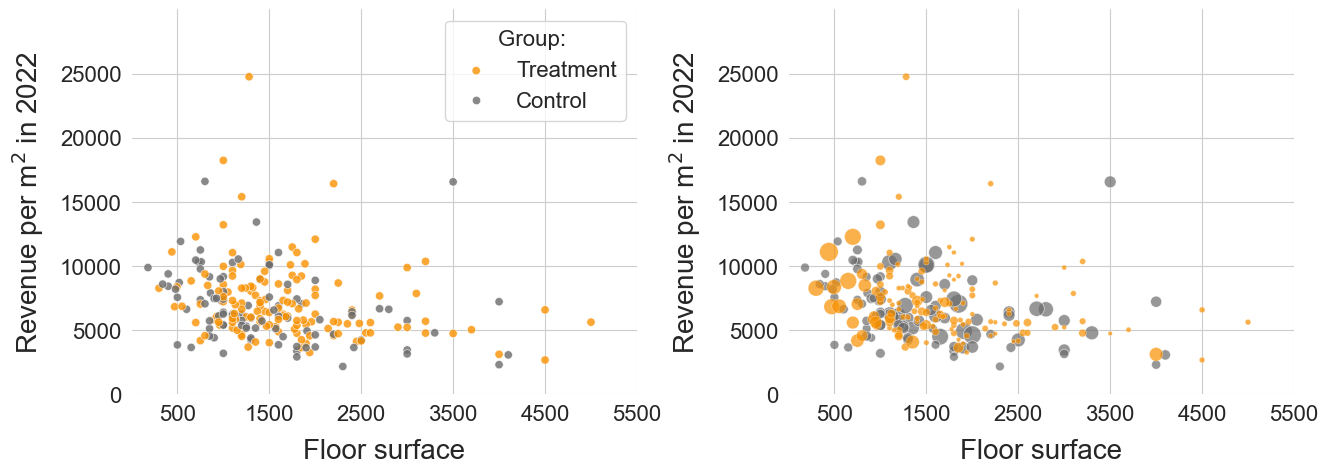

In [136]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 2, wspace=0.3)
# ax0 = plt.subplot(gs[0, 0:4])
ax0 = plt.subplot(gs[0, 0:1])
sns.scatterplot(
    data=data_gb_trim, y='revenue_m2_22', x='floor_surface', 
    hue="campaign", palette=colors, alpha=0.8, ax=ax0, sizes=150)
ax0.legend(title="Group: ", labels=["Treatment", "Control"]);
ax0.set_ylabel(ylabel="Revenue per m$^{2}$ in 2022", labelpad=10)
ax0.set_xlabel(xlabel="Floor surface", labelpad=10)
ax0.set_ylim(1, 30000)
plt.yticks(range(-0, 28000, 5000)) 
ax0.set_xlim(1, 5500)
ax0.set_xticks(range(500, 5900, 1000)) 

ax1 = plt.subplot(gs[0, 1:2])
sns.scatterplot(
    data=data_gb_trim[data_gb_trim["campaign"] == 0], y='revenue_m2_22', x='floor_surface', 
    color=colors[0], alpha=0.7, ax=ax1, size=weight_nt, sizes=(40, 180)
)
sns.scatterplot(
    data=data_gb_trim[data_gb_trim["campaign"] == 1], y='revenue_m2_22', x='floor_surface', 
    color=colors[1], alpha=0.7, ax=ax1, size=weight_t, sizes=(10, 180)
)
ax1.legend().set_visible(False)
ax1.set_ylabel(ylabel="Revenue per m$^{2}$ in 2022", labelpad=10)
ax1.set_xlabel(xlabel="Floor surface", labelpad=10)
ax1.set_ylim(1, 30000)
plt.yticks(range(-0, 28000, 5000)) 
ax1.set_xlim(1, 5500)
ax1.set_xticks(range(500, 5900, 1000)) 

for ax in [ax1, ax0]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.show()

### 3.4. Model diagnostics 2/2

#### **Distribution plots**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


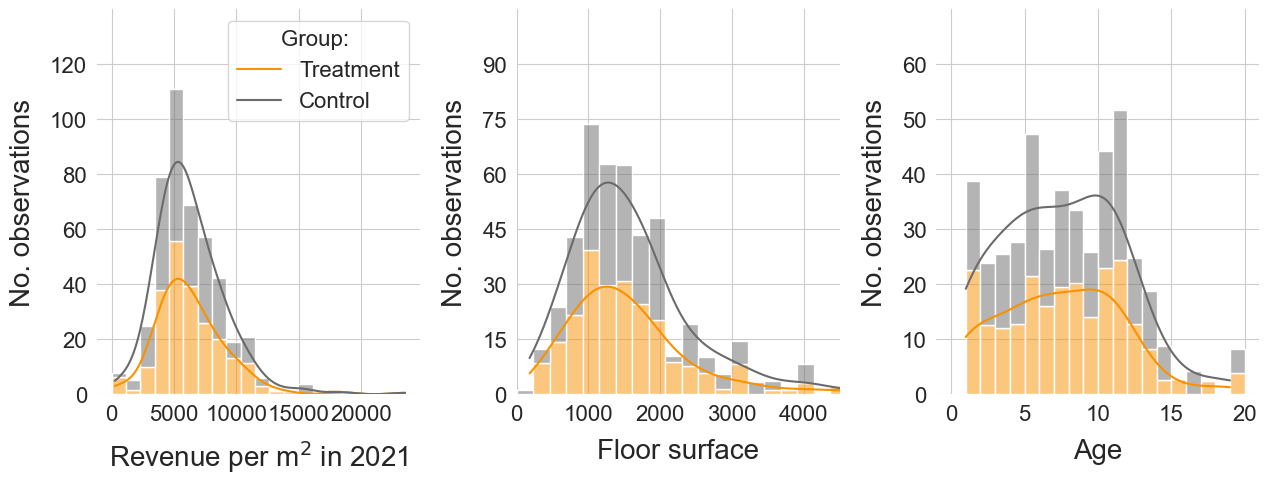

In [137]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.3)
ax0 = plt.subplot(gs[0, 0:1])
sns.histplot(
    data=data_gb_trim, x='revenue_m2_21', hue="campaign", weights='weight', ax=ax0,
    multiple='stack', kde=True, palette=colors, bins=20, binrange=[0, 23000])
ax0.set_ylabel(ylabel="No. observations", labelpad=10)
ax0.set_xlabel(xlabel="Revenue per m$^{2}$ in 2021", labelpad=10)
ax0.set_ylim(1, 140)
plt.yticks(range(0, 130, 20)) 
# ax0.set_xlim(1, 24000)
ax0.set_xticks(range(0, 24000, 5000)) 
ax0.legend(title="Group: ", labels=["Treatment", "Control"]);

ax1 = plt.subplot(gs[0, 1:2])
sns.histplot(
    data=data_gb_trim, x='floor_surface', hue="campaign", weights='weight', ax=ax1,
    multiple='stack', kde=True, palette=colors, bins=20, binrange=[0, 4600])
ax1.set_ylabel(ylabel="No. observations", labelpad=10)
ax1.set_xlabel(xlabel="Floor surface", labelpad=10)
ax1.set_ylim(1, 105)
ax1.set_yticks(range(0, 100, 15)) 
ax1.set_xlim(1, 4500)
ax1.set_xticks(range(0, 4600, 1000)) 
ax1.legend().set_visible(False)

ax2 = plt.subplot(gs[0, 2:3])
sns.histplot(
    data=data_gb_trim, x='age', hue="campaign", weights='weight', ax=ax2,
    multiple='stack', kde=True, palette=colors, bins=20, binrange=[0, 20])
ax2.set_ylabel(ylabel="No. observations", labelpad=10)
ax2.set_xlabel(xlabel="Age", labelpad=10)
ax2.set_ylim(1, 70)
ax2.set_yticks(range(0, 70, 10)) 
# ax2.set_xlim(1, 4800)
ax2.set_xticks(range(0, 23, 5)) 
ax2.legend().set_visible(False)

for ax in [ax0, ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.show()

#### **Standardized means difference**

In [138]:
def weighted_smd(treatment_x, control_x, treatment_weights, control_weights):
    """
    Implements standardized mean difference (SMD) that is a measure to assess 
    the balance in the marginal distributions of covariates.
    """
    treatment_mean = np.average(treatment_x, weights=treatment_weights)
    control_mean = np.average(control_x, weights=control_weights)

    treatment_var = np.average((treatment_x - treatment_mean)**2, weights=treatment_weights)
    control_var = np.average((control_x - control_mean)**2, weights=control_weights)

    SMD = (treatment_mean - control_mean) / np.sqrt((treatment_var + control_var) / 2)
    return SMD

def average_smd(smd_list):
    """
    Computes average absolute standardized mean difference of all covariates
    """
    return np.mean(np.abs(smd_list))

def run_smd(df, X, T, W):
    """
    Calculates SMD; used to produce confidence intervals of SMD
    """
    treatment_x = df[df[T] == 1][cov]
    control_x = df[df[T] == 0][cov]
    treatment_weights = df[df[T] == 1][W]
    control_weights = df[df[T] == 0][W]
    smd = weighted_smd(treatment_x, control_x, treatment_weights, control_weights)
    return smd

In [139]:
smd_list = []
for cov in COVARIATES:
    treatment_x = data_gb_trim[data_gb_trim[TREATMENT] == 1][cov]
    control_x = data_gb_trim[data_gb_trim[TREATMENT] == 0][cov]
    treatment_weights = data_gb_trim[data_gb_trim[TREATMENT] == 1]["weight"]
    control_weights = data_gb_trim[data_gb_trim[TREATMENT] == 0]["weight"]

    np.random.seed(88)
    bootstrap_sample = 1000
    smds = Parallel(n_jobs=4)(delayed(run_smd)(
        data_gb_trim.sample(frac=1, replace=True), cov, TREATMENT, "weight"
    ) for _ in range(bootstrap_sample))
    smds = np.array(smds)
    ci_l, ci_u = np.quantile(smds, [0.025, 0.975])
    
    smd = {
        "Variable": cov,
        "Mean_treat_before": treatment_x.mean(),
        "Mean_cont_before": control_x.mean(),
        "SMD_before": weighted_smd(treatment_x, control_x, [1] * len(treatment_weights), [1] * len(control_weights)),
        "Mean_treat": np.average(treatment_x, weights=treatment_weights),
        "Mean_cont": np.average(control_x, weights=control_weights),
        "SMD": weighted_smd(treatment_x, control_x, treatment_weights, control_weights),
        # "SMD_lower": ci_l,
        # "SMD_upper": ci_u
    }
    smd_list.append(smd)
smd_df = pd.DataFrame(smd_list)
smd_df

,Variable,Mean_treat_before,Mean_cont_before,SMD_before,Mean_treat,Mean_cont,SMD
0,floor_surface,1680.475,1463.368,0.263,1544.540,1590.340,-0.056
1,age,7.610,7.116,0.119,7.416,7.695,-0.067
2,revenue_m2_21,6373.696,6189.237,0.064,6419.292,6202.140,0.077


### 3.5. Average Treatment Effect estimation

In [140]:
def run_ate(df, X, T, Y, metric="ATE"):
    """Calculates ATE, ATT or ATC; used to produce confidence intervals"""
    X_set = sm.add_constant(df[X])
    logit_mod = LogisticRegression(random_state=2, max_iter=500).fit(
        X_set,
        df[TREATMENT]
    )
    ps = logit_mod.predict_proba(X_set)[:, 1]
    if metric.lower() == "ate":
        weight = (df[T] - ps) / (ps * (1 - ps))
    elif metric.lower() == "att":
        weight = (df[T] - ps) / (1 - ps)
    elif metric.lower() == "atc":
        weight = (df[T] - ps) / ps
    else:
        return None
    return np.mean(weight * df[Y])

np.random.seed(1)
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ate)(
    data_gb_trim.sample(frac=1, replace=True), COVARIATES, TREATMENT, OUTCOME
) for _ in range(bootstrap_sample))
ates = np.array(ates)

atts = Parallel(n_jobs=4)(delayed(run_ate)(
    data_gb_trim.sample(frac=1, replace=True), COVARIATES, TREATMENT, OUTCOME, "ATT"
) for _ in range(bootstrap_sample))
atts = np.array(atts)

atcs = Parallel(n_jobs=4)(delayed(run_ate)(
    data_gb_trim.sample(frac=1, replace=True), COVARIATES, TREATMENT, OUTCOME, "ATC"
) for _ in range(bootstrap_sample))
atcs = np.array(atcs)

#### **ATE**

In [141]:
N = len(data_gb_trim)
y1 = sum(data_gb_trim.query("campaign==1")["revenue_m2_22"] * weight_t) / N
y0 = sum(data_gb_trim.query("campaign==0")["revenue_m2_22"] * weight_nt) / N

ate = y1 - y0
print("ATE:", round(ate, 3), "PLN")
print(f"Confidence interval: ({np.percentile(ates, 2.5)}; {np.percentile(ates, 97.5)})")

ATE: 720.875 PLN
Confidence interval: (-364.02924863858124; 732.1140920602217)


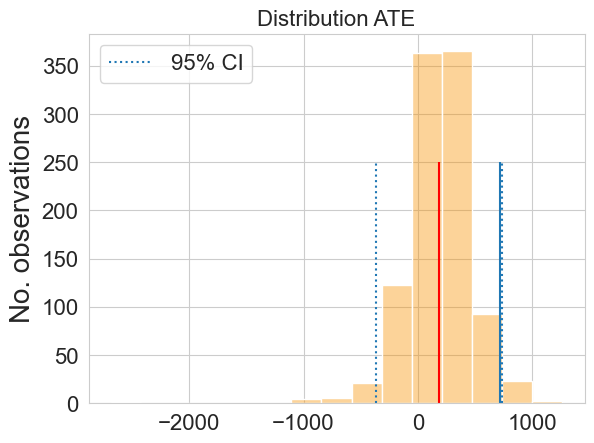

In [142]:
sns.histplot(ates, kde=False, alpha=0.4, bins=15, color=colors[1])
plt.vlines(np.percentile(ates, 2.5), 0, 250, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 250, linestyles="dotted", label="95% CI")
plt.vlines(x=ate, ymin=0, ymax=250)
plt.vlines(x=ates.mean(), ymin=0, ymax=250, colors="red")
plt.ylabel("No. observations")
plt.title("Distribution ATE")
plt.legend();

#### **ATT**

In [143]:
data_gb_trim["weights_att"] = (data_gb_trim[TREATMENT] - \
                               data_gb_trim["propensity_score"]) / (1 - data_gb_trim["propensity_score"])
att = np.sum(data_gb_trim["weights_att"] * data_gb_trim['revenue_m2_22']) / N
print("ATT:", round(att, 3), "PLN")
print(f"Confidence interval: ({np.percentile(atts, 2.5)}; {np.percentile(atts, 97.5)})")

ATT: 620.062 PLN
Confidence interval: (-466.65796658356413; 576.9355395832578)


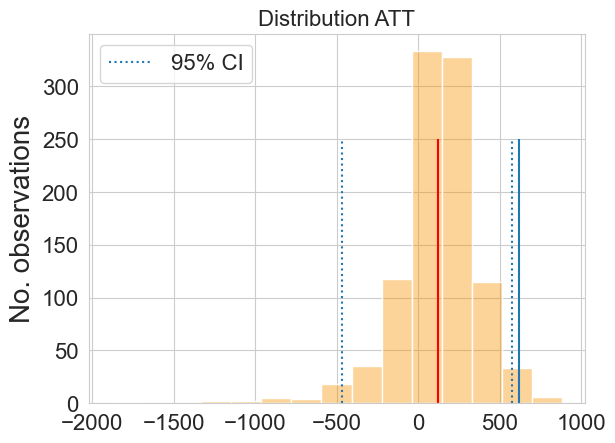

In [144]:
sns.histplot(atts, kde=False, alpha=0.4, bins=15, color=colors[1])
plt.vlines(np.percentile(atts, 2.5), 0, 250, linestyles="dotted")
plt.vlines(np.percentile(atts, 97.5), 0, 250, linestyles="dotted", label="95% CI")
plt.vlines(x=att, ymin=0, ymax=250)
plt.vlines(x=atts.mean(), ymin=0, ymax=250, colors="red")
plt.ylabel("No. observations")
plt.title("Distribution ATT")
plt.legend();

#### **ATC**

In [145]:
data_gb_trim["weights_atc"] = (data_gb_trim[TREATMENT] - \
                               data_gb_trim["propensity_score"]) / data_gb_trim["propensity_score"]
atc = np.sum(data_gb_trim["weights_atc"] * data_gb_trim['revenue_m2_22']) / N
print("ATC:", round(atc, 2), "PLN")
print(f"Confidence interval: ({np.percentile(atcs, 2.5)}; {np.percentile(atcs, 97.5)})")

ATC: 100.81 PLN
Confidence interval: (-108.12806860279302; 186.97217667543964)


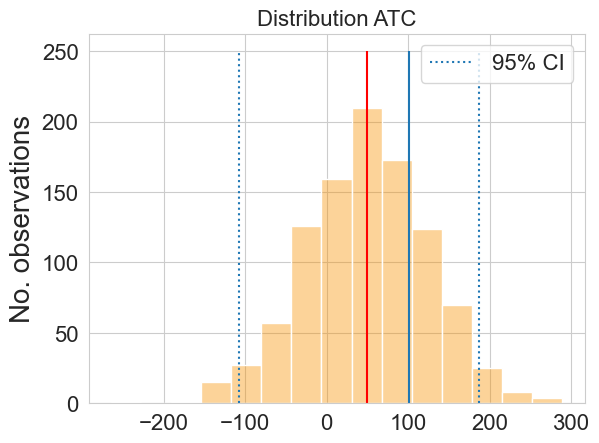

In [146]:
sns.histplot(atcs, kde=False, alpha=0.4, bins=15, color=colors[1])
plt.vlines(np.percentile(atcs, 2.5), 0, 250, linestyles="dotted")
plt.vlines(np.percentile(atcs, 97.5), 0, 250, linestyles="dotted", label="95% CI")
plt.vlines(x=atc, ymin=0, ymax=250)
plt.vlines(x=atcs.mean(), ymin=0, ymax=250, colors="red")
plt.ylabel("No. observations")
plt.title("Distribution ATC")
plt.legend();

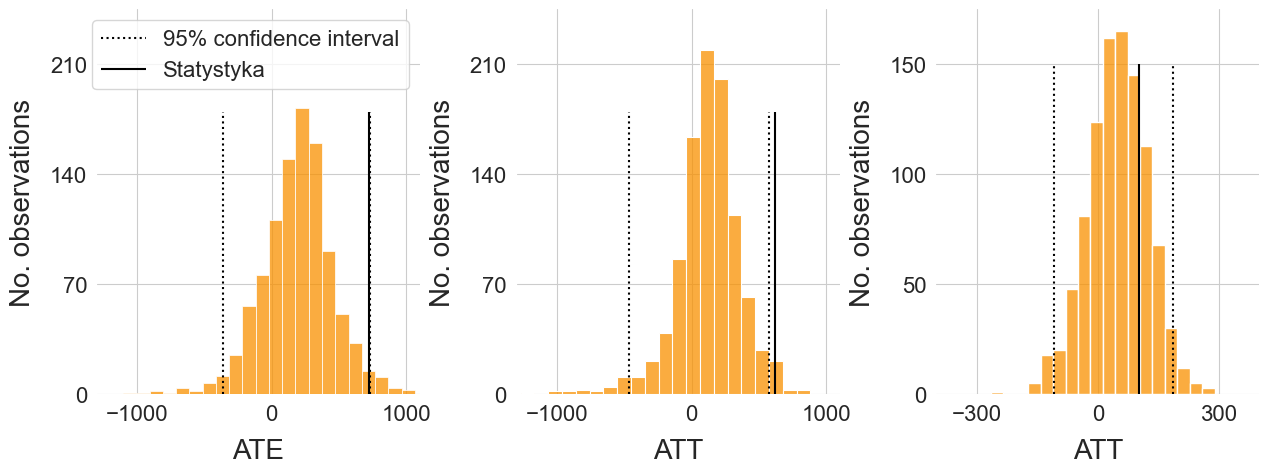

In [147]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.3)
ax0 = plt.subplot(gs[0, 0:1])
sns.histplot(
    ates, ax=ax0, color=colors[1], bins=40,
)
ax0.set_ylabel(ylabel="No. observations", labelpad=10)
ax0.set_xlabel(xlabel="ATE", labelpad=10)
ax0.set_ylim(1, 245)
ax0.set_yticks(range(0, 260, 70)) 
ax0.set_xlim(-1300, 1100)
ax0.set_xticks(range(-1000, 1100, 1000)) 
plt.vlines(np.percentile(ates, 2.5), 0, 180, linestyles="dotted", color="black")
plt.vlines(np.percentile(ates, 97.5), 0, 180, linestyles="dotted", color="black", label="95% confidence interval")
# plt.vlines(x=ates.mean(), ymin=0, ymax=180, colors="black", label="Mean")
plt.vlines(x=ate, ymin=0, ymax=180, colors="black", label="Statystyka")
plt.legend();

# ax0.text(np.percentile(ates, 2.5)-400, 155, round(np.percentile(ates, 2.5), 3))

ax1 = plt.subplot(gs[0, 1:2])
sns.histplot(
    atts, ax=ax1, color=colors[1], bins=27, 
)
ax1.set_ylabel(ylabel="No. observations", labelpad=10)
ax1.set_xlabel(xlabel="ATT", labelpad=10)
ax1.set_ylim(1, 245)
ax1.set_yticks(range(0, 260, 70)) 
ax1.set_xlim(-1300, 1100)
ax1.set_xticks(range(-1000, 1100, 1000)) 
plt.vlines(np.percentile(atts, 2.5), 0, 180, linestyles="dotted", color="black")
plt.vlines(np.percentile(atts, 97.5), 0, 180, linestyles="dotted", color="black")
# plt.vlines(x=atts.mean(), ymin=0, ymax=180, colors="black")
plt.vlines(x=att, ymin=0, ymax=180, colors="black")


ax2 = plt.subplot(gs[0, 2:3])
sns.histplot(
    atcs, ax=ax2, color=colors[1], bins=18, 
)
ax2.set_ylabel(ylabel="No. observations", labelpad=10)
ax2.set_xlabel(xlabel="ATT", labelpad=10)
ax2.set_ylim(1, 175)
ax2.set_yticks(range(0, 160, 50)) 
ax2.set_xlim(-400, 400)
ax2.set_xticks(range(-300, 400, 300)) 
plt.vlines(np.percentile(atcs, 2.5), 0, 150, linestyles="dotted", color="black")
plt.vlines(np.percentile(atcs, 97.5), 0, 150, linestyles="dotted", color="black")
# plt.vlines(x=atcs.mean(), ymin=0, ymax=150, colors="black", label="Mean")
plt.vlines(x=atc, ymin=0, ymax=150, colors="black", label="Mean")


for ax in [ax0, ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.show()

### 3.6. Propensity score matching

In [148]:
# 243
gb_mod = GradientBoostingClassifier(
    n_estimators=1600, max_depth=2, learning_rate=0.0003, subsample=0.5, random_state=0
).fit(
    data_gb[COVARIATES],
    data_gb[TREATMENT]
)

In [149]:
ps = gb_mod.predict_proba(
    data_gb[COVARIATES]
)[:, 1]
data_gb["propensity_score"] = ps
data_gb["class_prob"] = np.where(
    data_gb["campaign"] == 1, 
    data_gb["propensity_score"], 
    1 - data_gb["propensity_score"]
)

#### **Common support**

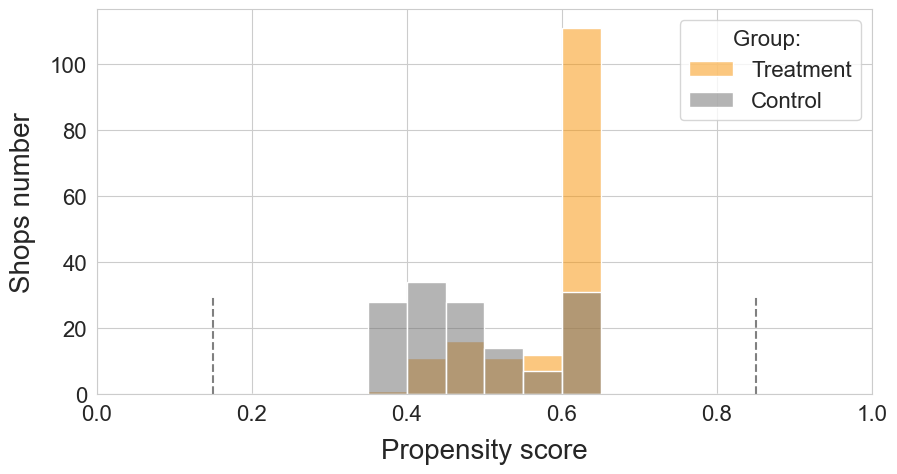

In [150]:
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 1)
# ax0 = plt.subplot(gs[0, 0:4])
ax = plt.subplot(gs[0, 0:6])
sns.histplot(data=data_gb, x='propensity_score', 
    fill=True, hue="campaign", alpha=0.5, 
    binrange=[0,1], binwidth=0.05, palette=colors
)

ax.set_ylabel(ylabel="Shops number", labelpad=10)
# ax.set_ylim(0, 40)
# plt.yticks(range(5, 31, 5))

ax.set_xlabel(xlabel="Propensity score", labelpad=10)
ax.set_xlim(0, 1)
plt.xticks(np.array(range(0, 11, 2))/10) 
plt.legend(title="Group: ", labels=["Treatment", "Control"]);

ax.vlines(x=.15, ymin=0, ymax=30, colors="grey", linestyles="--")
ax.vlines(x=.85, ymin=0, ymax=30, colors="grey", linestyles="--")

plt.show()

In [151]:
data_gb_trim = data_gb[(data_gb["propensity_score"] > 0.4) & (data_gb["propensity_score"] < .85)].copy()
data_gb.shape, data_gb_trim.shape

((304, 11), (275, 11))

#### **Checking whether the distribution of PS is similar between groups**

In [152]:
results = pd.DataFrame()
N = 6
for q in range(1, N):
    for g in [0, 1]:
        ps_tmp = data_gb_trim[data_gb_trim[TREATMENT] == g]["propensity_score"]
        v1, v2 = np.quantile(ps_tmp, [(q-1)*0.2, q*0.2])
        ps_tmp = ps_tmp[(ps_tmp < v2) & (ps_tmp > v1)]
        min = ps_tmp.min()
        max = ps_tmp.max()
        avg = ps_tmp.mean()
        res_row = pd.DataFrame({
            "Quintile": [q],
            "Group": [g],
            "Min": [min],
            "Max": [max],
            "Mean": [avg]
        })
        results = pd.concat([results, res_row])
results.reset_index(drop=True)

,Quintile,Group,Min,Max,Mean
0,1,0,0.405,0.432,0.419
1,1,1,0.424,0.514,0.467
2,2,0,0.433,0.466,0.451
3,2,1,0.526,0.605,0.586
4,3,0,0.466,0.511,0.488
5,3,1,0.607,0.611,0.608
6,4,0,0.512,0.608,0.576
7,4,1,0.611,0.617,0.614
8,5,0,0.608,0.619,0.613
9,5,1,0.618,0.623,0.621


#### **Matching**

In [153]:
data_gb_trim = data_gb_trim[[
    'floor_surface', 'age', 'revenue_m2_21', 'campaign',
    'revenue_m2_22', 'propensity_score', 'class_prob'
]]

In [154]:
treated_df = data_gb_trim.query("campaign == 1")
untreated_df = data_gb_trim.query("campaign == 0")

In [155]:
treated_pairs = pd.DataFrame()
for i, row in treated_df.iterrows():
    match = (np.abs(untreated_df["propensity_score"] - row["propensity_score"])).idxmin()
    match_df = untreated_df.loc[[match]].reset_index()
    cols = [c + "_match" for c in match_df.columns]
    match_df.columns = cols
    df = pd.concat([treated_df.loc[[i]].reset_index(), match_df], axis=1)
    treated_pairs = pd.concat([treated_pairs, df], axis=0)

treated_pairs = treated_pairs.reset_index(drop=True)

In [156]:
untreated_pairs = pd.DataFrame()
for i, row in untreated_df.iterrows():
    match = (np.abs(treated_df["propensity_score"] - row["propensity_score"])).idxmin()
    match_df = treated_df.loc[[match]].reset_index()
    cols = [c + "_match" for c in match_df.columns]
    match_df.columns = cols
    df = pd.concat([untreated_df.loc[[i]].reset_index(), match_df], axis=1)
    untreated_pairs = pd.concat([untreated_pairs, df], axis=0)

untreated_pairs = untreated_pairs.reset_index(drop=True)

In [157]:
matched_df = pd.concat([untreated_pairs, treated_pairs])
matched_df

,index,floor_surface,age,revenue_m2_21,campaign,revenue_m2_22,propensity_score,class_prob,index_match,floor_surface_match,age_match,revenue_m2_21_match,campaign_match,revenue_m2_22_match,propensity_score_match,class_prob_match
0,1,1000,3,8707.300,0,9177.000,0.509,0.491,210,5000,14,3436.000,1,5629.200,0.509,0.509
1,3,900,4,6017.756,0,4414.140,0.416,0.584,242,440,7,10466.155,1,11104.770,0.415,0.415
2,4,1800,2,3397.416,0,3378.539,0.498,0.502,42,1200,1,3368.938,1,4995.973,0.494,0.494
3,5,980,3,6256.776,0,7282.717,0.489,0.511,75,1500,1,2936.368,1,5424.993,0.486,0.486
4,6,1300,3,3932.895,0,4248.515,0.549,0.451,170,1000,10,6551.751,1,7225.890,0.549,0.549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,322,2600,4,5523.741,1,5598.187,0.609,0.609,286,2400,5,5683.168,0,6157.030,0.610,0.390
157,327,2600,4,4624.204,1,4795.048,0.607,0.607,326,3300,4,4547.248,0,4797.082,0.607,0.393
158,331,2220,10,6917.862,1,7292.481,0.622,0.622,108,1850,11,7093.414,0,7060.134,0.621,0.379
159,334,2000,10,7157.342,1,7756.377,0.622,0.622,108,1850,11,7093.414,0,7060.134,0.621,0.379


#### **Model diagnostics**

In [158]:
def smd(treatment_x, control_x):
    """
    Implements standardized mean difference (SMD) that is a measure to assess 
    the balance in the marginal distributions of covariates.
    """
    treatment_mean = np.average(treatment_x)
    control_mean = np.average(control_x)

    treatment_var = np.average((treatment_x - treatment_mean)**2)
    control_var = np.average((control_x - control_mean)**2)

    SMD = (treatment_mean - control_mean) / np.sqrt((treatment_var + control_var) / 2)
    return SMD

In [159]:
smd_list = []
for cov in COVARIATES:
    treatment_x = treated_pairs[cov]
    treatment_x_matches = treated_pairs[cov + "_match"]
    control_x = untreated_pairs[cov]
    control_x_matches = untreated_pairs[cov + "_match"]
    smd_dict = {
        "Variable": cov,
        "Mean_treatment": treatment_x.mean(),
        # "SMD_before": smd(treatment_x, control_x),
        "Mean_control": control_x.mean(),
        
        "Mean_treatment_matches": treatment_x_matches.mean(),
        "Mean_control_matches": control_x_matches.mean(),
        
        "SMD_treatment": smd(treatment_x, treatment_x_matches),
        "SMD_control": smd(control_x, control_x_matches),
    }
    smd_list.append(smd_dict)
smd_df = pd.DataFrame(smd_list)
smd_df

,Variable,Mean_treatment,Mean_control,Mean_treatment_matches,Mean_control_matches,SMD_treatment,SMD_control
0,floor_surface,1782.677,1373.860,1778.261,1410.474,0.005,-0.037
1,age,7.733,7.509,7.981,6.605,-0.058,0.236
2,revenue_m2_21,6323.353,6182.128,6191.042,6136.307,0.050,0.014


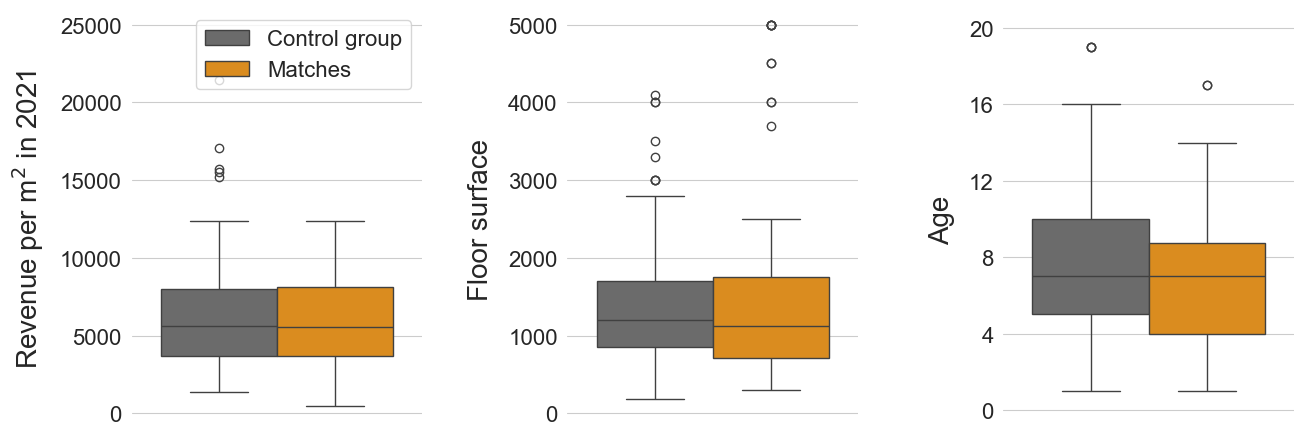

In [160]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.5, top=0.95)

treated_pairs_tmp = pd.melt(untreated_pairs[["revenue_m2_21", "revenue_m2_21_match", "campaign"]], id_vars=["campaign"])
treated_pairs_tmp["variable"] = treated_pairs_tmp["variable"].map({'revenue_m2_21': 'Control group', 'revenue_m2_21_match': 'Matches'})
treated_pairs_tmp

ax0 = plt.subplot(gs[0, 0])
sns.boxplot(
    data=treated_pairs_tmp, y='value',
    palette=colors, hue="variable", ax=ax0
)
ax0.set_ylabel(ylabel="Revenue per m$^{2}$ in 2021", labelpad=10)
ax0.set_ylim(-1000, 26000)
ax0.set_yticks(range(0, 26000, 5000)) 
ax0.legend_.set_title(None)

treated_pairs_tmp = pd.melt(untreated_pairs[["floor_surface", "floor_surface_match", "campaign"]], id_vars=["campaign"])
treated_pairs_tmp["variable"] = treated_pairs_tmp["variable"].map({'floor_surface': 'Control group', 'floor_surface_match': 'Matches'})
treated_pairs_tmp

ax1 = plt.subplot(gs[0, 1])
sns.boxplot(
    data=treated_pairs_tmp, y='value',
    palette=colors, hue="variable", ax=ax1
)
ax1.legend_.set_title(None)
ax1.set_ylabel(ylabel="Floor surface", labelpad=10)
ax1.legend().set_visible(False)
ax1.set_ylim(-200, 5200)
ax1.set_yticks(range(0, 6000, 1000)) 

treated_pairs_tmp = pd.melt(untreated_pairs[["age", "age_match", "campaign"]], id_vars=["campaign"])
treated_pairs_tmp["variable"] = treated_pairs_tmp["variable"].map({'age': 'Control group', 'age_match': 'Matches'})
treated_pairs_tmp

ax2 = plt.subplot(gs[0, 2])
sns.boxplot(
    data=treated_pairs_tmp, y='value',
    palette=colors, hue="variable", ax=ax2
)
ax2.set_ylabel(ylabel="Age", labelpad=10)
ax2.legend().set_visible(False)
ax2.set_ylim(-1, 21)
ax2.set_yticks(range(0, 22, 4)) 

for ax in [ax0, ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.show()

In [161]:
cm = CausalModel(
    Y=data_gb_trim["revenue_m2_22"].values, 
    D=data_gb_trim["campaign"].values, 
    X=data_gb_trim[["propensity_score"]].values
)

cm.est_via_matching(matches=1)
print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE    489.214    614.097      0.797      0.426   -714.415   1692.844
           ATC    620.773    703.296      0.883      0.377   -757.687   1999.233
           ATT    396.061    776.664      0.510      0.610  -1126.200   1918.322



In [162]:
np.mean(
    (2 * matched_df["campaign"] - 1) * matched_df["revenue_m2_22"] + \
    (1 - 2 * matched_df["campaign"]) * matched_df["revenue_m2_22_match"]
)

489.21426

In [163]:
np.mean(treated_pairs["revenue_m2_22"] - treated_pairs["revenue_m2_22_match"])

396.06086

In [164]:
np.mean(untreated_pairs["revenue_m2_22_match"] - untreated_pairs["revenue_m2_22"])

620.77300